# Projet n°6: "Classifiez automatiquement des biens de consommation"

## OBJECTIF 

Réaliser une étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

In [300]:
# bibliothèque
import numpy as np
import pandas as pd
import string
import os
#for visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
# for NLP
import nltk
import texthero as hero
from texthero import preprocessing
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from gensim.models import Word2Vec
import multiprocessing
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from texthero import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn import (preprocessing,
                     manifold,
                     decomposition)
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import cluster, metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# Clustering Metrics
from sklearn.metrics.cluster import adjusted_rand_score
import statistics
from sklearn.metrics import confusion_matrix




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mehan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mehan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 1-Jeu de données

In [301]:
# imporation data
data=pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [302]:
data.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

In [303]:
# Taille : nombre de lignes/colonnes
nRow, nVar = data.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1050 lignes et 15 variables.


In [304]:
data.columns.tolist()

['uniq_id',
 'crawl_timestamp',
 'product_url',
 'product_name',
 'product_category_tree',
 'pid',
 'retail_price',
 'discounted_price',
 'image',
 'is_FK_Advantage_product',
 'description',
 'product_rating',
 'overall_rating',
 'brand',
 'product_specifications']

In [305]:
#types de variables
data.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [306]:
# variables manquantes
data.isna().mean()*100

uniq_id                     0.000000
crawl_timestamp             0.000000
product_url                 0.000000
product_name                0.000000
product_category_tree       0.000000
pid                         0.000000
retail_price                0.095238
discounted_price            0.095238
image                       0.000000
is_FK_Advantage_product     0.000000
description                 0.000000
product_rating              0.000000
overall_rating              0.000000
brand                      32.190476
product_specifications      0.095238
dtype: float64

<AxesSubplot:title={'center':'Missing Value'}>

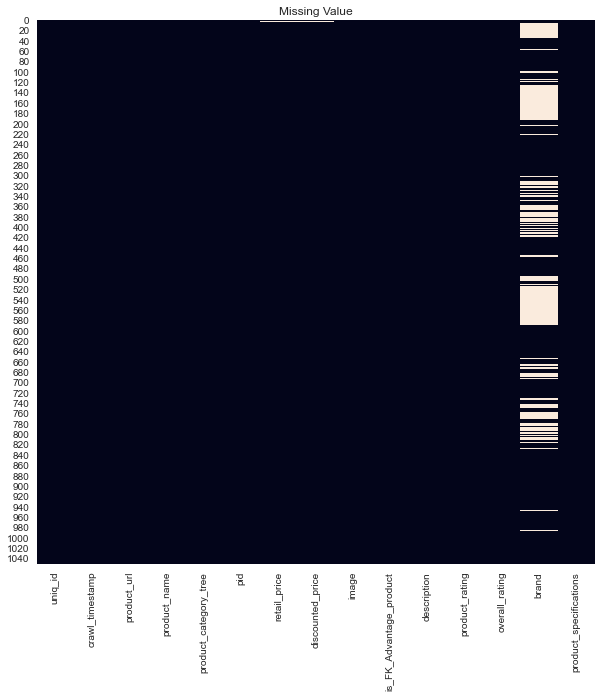

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

df = data
plt.figure(figsize=(10,10)) #Réglage de la taille
plt.title("Missing Value") #Titre
sns.heatmap(df.isnull(), cbar=False) #Affichage de la carte thermique


### Le jeu de données comporte peu de valeurs manquantes (~ 2%), seule la variable 'brand' comporte plus de 30% de valeurs manquantes.

## 2-Analyse exploratoire des variables

### comprehension des variables

In [308]:
# uniq_id / product_url / pid - Identifiants uniques
data.uniq_id.head()

0    55b85ea15a1536d46b7190ad6fff8ce7
1    7b72c92c2f6c40268628ec5f14c6d590
2    64d5d4a258243731dc7bbb1eef49ad74
3    d4684dcdc759dd9cdf41504698d737d8
4    6325b6870c54cd47be6ebfbffa620ec7
Name: uniq_id, dtype: object

In [309]:
data.product_url.head()

0    http://www.flipkart.com/elegance-polyester-mul...
1    http://www.flipkart.com/sathiyas-cotton-bath-t...
2    http://www.flipkart.com/eurospa-cotton-terry-f...
3    http://www.flipkart.com/santosh-royal-fashion-...
4    http://www.flipkart.com/jaipur-print-cotton-fl...
Name: product_url, dtype: object

In [310]:
data.pid.head()

0    CRNEG7BKMFFYHQ8Z
1    BTWEGFZHGBXPHZUH
2    BTWEG6SHXTDB2A2Y
3    BDSEJT9UQWHDUBH4
4    BDSEJTHNGWVGWWQU
Name: pid, dtype: object

In [311]:
data.product_name.head()

0    Elegance Polyester Multicolor Abstract Eyelet ...
1                           Sathiyas Cotton Bath Towel
2                  Eurospa Cotton Terry Face Towel Set
3    SANTOSH ROYAL FASHION Cotton Printed King size...
4    Jaipur Print Cotton Floral King sized Double B...
Name: product_name, dtype: object

####  Variables non conservées pour la suite : uniq_id, pid et product_url.
#### Variable conservée comme clé unique : product_name.

In [312]:
# crawl_timestamp	
data.crawl_timestamp.head()

0    2016-04-30 03:22:56 +0000
1    2016-04-30 03:22:56 +0000
2    2016-04-30 03:22:56 +0000
3    2016-06-20 08:49:52 +0000
4    2016-06-20 08:49:52 +0000
Name: crawl_timestamp, dtype: object

In [313]:
# Transforme de Object en Datetime
data['crawl_timestamp'] = pd.to_datetime(data['crawl_timestamp'])

In [314]:
# product_category_tree
data.product_category_tree.head(3)

0    ["Home Furnishing >> Curtains & Accessories >>...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
Name: product_category_tree, dtype: object

#### La variable product_category_tree est constituée de plusieurs sous-catégories de produits séparées

In [315]:
# regardons la 1 ligne 
data.product_category_tree[1].split('["')

['',
 'Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]']

In [316]:
# creation d'une fonction permettant de voir les 3 sous couches de catégories

def split_categories(category, level):
    '''Fonction qui affiche le nombre de modalités  '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

In [317]:
#on prend la premiere categorie de la liste 
def split_categories_1(category):
    return split_categories(category,0)
#on prend la deuxiéme catégore de la liste 
def split_categories_2(category):
    return split_categories(category,1)
#on prend la troisiéme catégorie de la liste 
def split_categories_3(category):
    return split_categories(category,2)

In [318]:
def detail_categories(dataframe):
    dataframe['cat_lvl_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['cat_lvl_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['cat_lvl_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe

In [319]:
data=detail_categories(data)
#on prend la colonne categories tree on prend les trois premieres éléments
#remplis par le vendeur
data.columns
#creation des colonnes categorie 1, 2 et 3

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'cat_lvl_1',
       'cat_lvl_2', 'cat_lvl_3'],
      dtype='object')

In [320]:
data.head(3)

uniq_id           crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56+00:00   
1  7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56+00:00   
2  64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications        cat_lvl_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   

                cat_lvl_2         cat_lvl_3  
0  Curtains & Accessories          Curtains  
1        Baby Bath & Skin  Baby Bath Towels  
2        Baby Bath & Skin  Baby Bath Towels

In [321]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
cat_lvl_1                    0
cat_lvl_2                    0
cat_lvl_3                    0
dtype: int64

In [322]:
data['cat_lvl_1'].head()

0    Home Furnishing
1          Baby Care
2          Baby Care
3    Home Furnishing
4    Home Furnishing
Name: cat_lvl_1, dtype: object

In [323]:
data['cat_lvl_1'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: cat_lvl_1, dtype: int64

In [324]:
df=pd.DataFrame({'Modalités':data['cat_lvl_1'].value_counts().index,'Frequence':data['cat_lvl_1'].value_counts().values})

In [325]:
df

Modalités  Frequence
0             Home Furnishing        150
1                   Baby Care        150
2                     Watches        150
3  Home Decor & Festive Needs        150
4            Kitchen & Dining        150
5    Beauty and Personal Care        150
6                   Computers        150

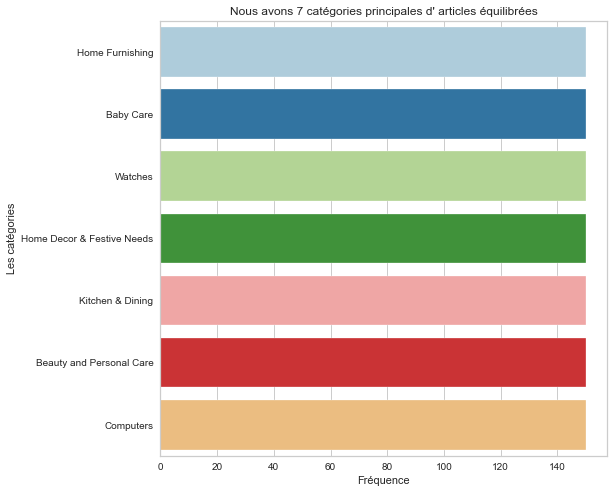

In [326]:
plt.figure(figsize =(8,8))
sns.barplot(y='Modalités',x='Frequence',data=df)
plt.title('Nous avons 7 catégories principales d\' articles équilibrées')
plt.xlabel('Fréquence')
plt.ylabel('Les catégories')
plt.show()

In [327]:
# voyons avec lebel 2
data['cat_lvl_2'].value_counts()

Wrist Watches                      149
Laptop Accessories                  87
Infant Wear                         84
Coffee Mugs                         74
Showpieces                          71
                                  ... 
Consumables & Disposables            1
TRUE Home Decor & Festive Needs      1
JMD Home Furnishing                  1
Kripa's Home Furnishing              1
Beauty Accessories                   1
Name: cat_lvl_2, Length: 62, dtype: int64

#### il y a 62 modalités !

In [328]:
df2=pd.DataFrame({'Modalités':data['cat_lvl_2'].value_counts().index,'Frequence':data['cat_lvl_2'].value_counts().values})

In [329]:
df2

Modalités  Frequence
0                     Wrist Watches        149
1                Laptop Accessories         87
2                       Infant Wear         84
3                       Coffee Mugs         74
4                        Showpieces         71
..                              ...        ...
57        Consumables & Disposables          1
58  TRUE Home Decor & Festive Needs          1
59              JMD Home Furnishing          1
60          Kripa's Home Furnishing          1
61               Beauty Accessories          1

[62 rows x 2 columns]

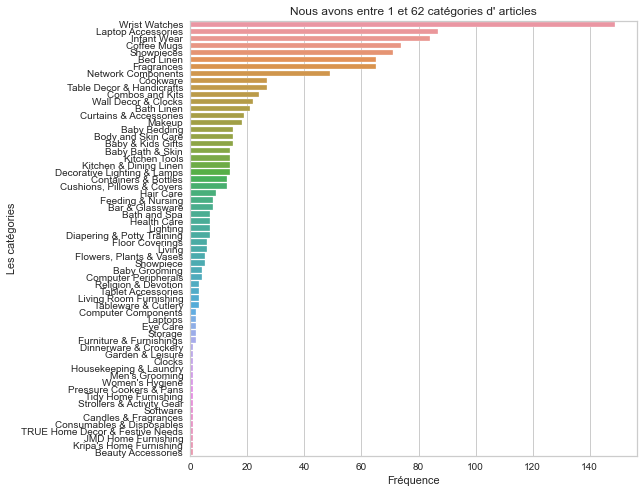

In [330]:
plt.figure(figsize =(8,8))
sns.barplot(y='Modalités',x='Frequence',data=df2)
plt.title('Nous avons entre 1 et 62 catégories d\' articles')
plt.xlabel('Fréquence')
plt.ylabel('Les catégories')
plt.show()

In [331]:
# voyons avec level 3
data['cat_lvl_3'].value_counts()

Deodorants                   65
Blankets, Quilts & Dohars    57
Routers                      49
Baby Girls' Clothes          49
USB Gadgets                  38
                             ..
Portable Projectors           1
Changing Tables               1
Titan Wrist Watches           1
Table Linen Sets              1
Strollers & Prams             1
Name: cat_lvl_3, Length: 242, dtype: int64

### il y a 242 modalités !

In [332]:
df3=pd.DataFrame({'Modalités':data['cat_lvl_3'].value_counts().index,'Frequence':data['cat_lvl_3'].value_counts().values})

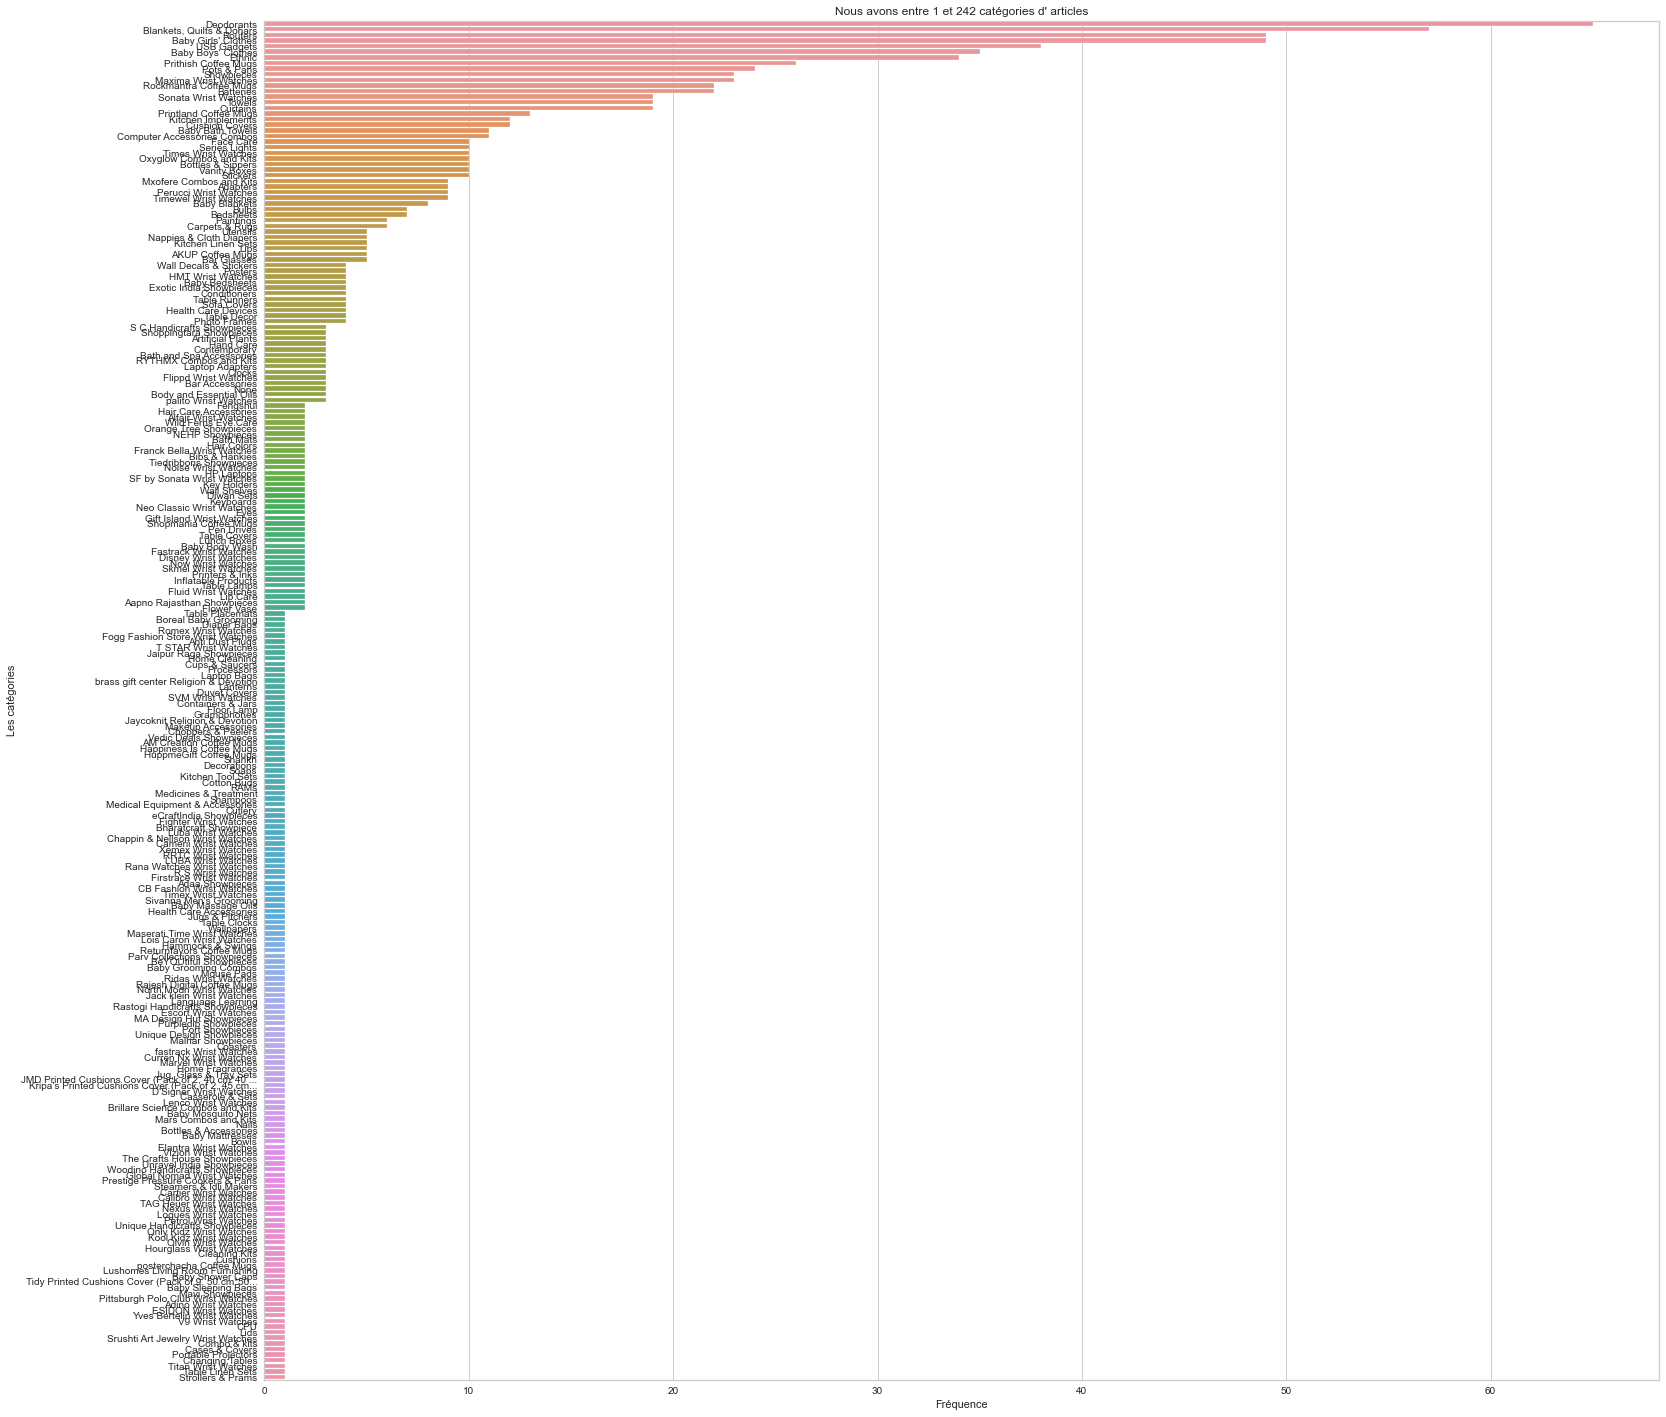

In [333]:
plt.figure(figsize =(25,25))
sns.barplot(y='Modalités',x='Frequence',data=df3)
plt.title('Nous avons entre 1 et 242 catégories d\' articles')
plt.xlabel('Fréquence')
plt.ylabel('Les catégories')
plt.show()

### Nous voyons qu'en prenant la categorie principale nous avons 7 catégories équilibrées dans notre base relativement à 2 ou 3 levels. nous allons travailler pour la suite avec la base df (7 modalités)

In [334]:
# rappel data
data.columns.tolist()

['uniq_id',
 'crawl_timestamp',
 'product_url',
 'product_name',
 'product_category_tree',
 'pid',
 'retail_price',
 'discounted_price',
 'image',
 'is_FK_Advantage_product',
 'description',
 'product_rating',
 'overall_rating',
 'brand',
 'product_specifications',
 'cat_lvl_1',
 'cat_lvl_2',
 'cat_lvl_3']

In [335]:
# image
data.image.head(3)

0    55b85ea15a1536d46b7190ad6fff8ce7.jpg
1    7b72c92c2f6c40268628ec5f14c6d590.jpg
2    64d5d4a258243731dc7bbb1eef49ad74.jpg
Name: image, dtype: object

In [336]:
# vérifions que chaque produit a une image
# chargement des images
from os import listdir
photo_image = []
for photo in os.listdir('Images'):
    photo_image.append(photo)
verif= data[~data['image'].isin(photo_image)]
verif

Empty DataFrame
Columns: [uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications, cat_lvl_1, cat_lvl_2, cat_lvl_3]
Index: []

#### Toutes les images ont bien un fichier de photographie dans le répertoire 'Images'.

In [337]:
# description
data.description.head(3)

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
Name: description, dtype: object

#### description textuelle du produit 

In [338]:
# product_specifications 
data.product_specifications.head(1)

0    {"product_specification"=>[{"key"=>"Brand", "v...
Name: product_specifications, dtype: object

#### différentes propriétés du produit-->ces informations sont aussi dans la variable description

### resumé,variables inutiles et base de travail

### les variables retail_price + discount_price+product_rating+overall_rating+FK_advantage_product sont des variables qui ne seront pas conservés car elles ne comportent pas d'informations textuelles ou images 

### La mission étant d'automatiser la classification des catégories des produits en fonction de leurs description + image nous gardonc donc les variables suivantes:
### *product_name
### * image
### *product_category_tree
### *cat_lvl_1
### *description


In [339]:
# base de travail
data=data[['product_name','image','product_category_tree','cat_lvl_1','description']]

In [340]:
data.head(3)

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                               product_category_tree        cat_lvl_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...

In [341]:
# nous procédons à la concaténation des colonnes product_name et description 
data['descriptif']=data.product_name + " " + data.description

In [342]:
data.descriptif

0       Elegance Polyester Multicolor Abstract Eyelet ...
1       Sathiyas Cotton Bath Towel Specifications of S...
2       Eurospa Cotton Terry Face Towel Set Key Featur...
3       SANTOSH ROYAL FASHION Cotton Printed King size...
4       Jaipur Print Cotton Floral King sized Double B...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker Wallman...
1047    Uberlyfe Extra Large Pigmented Polyvinyl Films...
1048    Wallmantra Medium Vinyl Sticker Sticker Buy Wa...
1049    Uberlyfe Large Vinyl Sticker Buy Uberlyfe Larg...
Name: descriptif, Length: 1050, dtype: object

In [343]:
def taille_mot(base,colonne):
  corpus=base[colonne]
  words_dico=dict()
  import re
  #importation des expressions réguliéres

  expr = re.compile("\W+",re.U) # Expression régulière de segmentation sur les espaces
  for text in corpus: # Pour chaque commentaire du corpus
    text = str(text)
    text = expr.split(text)
    for word in set(text): # Récupération de chaque nouveau mot
      if word not in words_dico:
        words_dico[word]=1
      else: 
          # Pour chaque mot déjà listé : ajouter 1 si on le retrouve
            words_dico[word]=words_dico[word]+1

  return len(words_dico)

In [344]:
taille_debut=taille_mot(data,'descriptif')
print(taille_debut)

7671


## 3-Preprocessing

#### Méthode classique :
Preprocessing du texte avec Bag-of-Words & TF-IDF.

##### Création d'une fonction pour nettoyer les données textuelles :
Case normalization.
Tokenization.
Remove punctuations.
Remove numbers.
Remove stop-words.
Lemmatization

In [345]:
def preprocess_text(dataframe, col_à_nettoyer, col_nettoyee, lemmatize):
    """
    Cette fonction prend comme input une colonne du dataframe en y applicant l'algorithme NLTK 
    """
   
    print("Text avant nettoyage")
    print("-" * 100)
    print(dataframe.loc[0, col_à_nettoyer])

    # lower case
    dataframe[col_nettoyee] = dataframe[col_à_nettoyer].apply(lambda x: str(x).lower())

    print("-" * 100)
    print("Step 1 : Case nomalization")
    print("-" * 100)
    print(dataframe.loc[0, col_nettoyee])

    # word tokenize
    dataframe[col_nettoyee] = dataframe[col_nettoyee].apply(lambda x: word_tokenize(str(x), language="english"))

    print("-" * 100)
    print("Step 2 : Tokenization")
    print("-" * 100)
    print(dataframe.loc[0, col_nettoyee])

    # Remove punctuations and numbers

    dataframe[col_nettoyee] = dataframe[col_nettoyee].apply(lambda x: [word for word in x if word.isalpha()])

    print("-" * 100)
    print("Step 3 : enlever ponctuation et chiffre")
    print("-" * 100)
    print(dataframe.loc[0, col_nettoyee])

    # Remove stop-words 
    dataframe[col_nettoyee] = dataframe[col_nettoyee].apply(lambda x: [word for word in x if word not in stopwords.words("english")])
   
    # supprimer les lettres seules de a à z

    dataframe[col_nettoyee] = dataframe[col_nettoyee].apply(lambda x: [word for word in x if len(word)>2])
                                                         
    print("-" * 100)
    print("Step 4 : stop-words")
    print("-" * 100)
    print(dataframe.loc[0, col_nettoyee])
    

    # Lemmatize tokens
    dataframe[col_nettoyee] = dataframe[col_nettoyee].apply(lambda x: [lemmatize.lemmatize(word, pos="n") for word in x])
    dataframe[col_nettoyee] = dataframe[col_nettoyee].apply(lambda x: [lemmatize.lemmatize(word, pos="v") for word in x])
    
    
    print("-" * 100)
    print("Step 5 : Lemmatization")
    print("-" * 100)
    print(dataframe.loc[0, col_nettoyee])
    
                                                            
    dataframe[col_nettoyee] = dataframe[col_nettoyee].apply(lambda x: " ".join(x))

    print("-" * 100)
    print("Step 6 : Final result")
    print("-" * 100)
    print(dataframe.loc[0, col_nettoyee])

    return None

In [346]:
# Nettoyage de colonne description et visualisation d'un exemple 
preprocess_text(dataframe=data,col_à_nettoyer="descriptif",col_nettoyee="descriptif_cleaned",
    lemmatize=WordNetLemmatizer(),)

Text avant nettoyage
----------------------------------------------------------------------------------------------------
Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close 

----------------------------------------------------------------------------------------------------
Step 5 : Lemmatization
----------------------------------------------------------------------------------------------------
['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhance', 'look', 'curtain', 'make', 'high', 'quality', 'polyester', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'make', 'room', 'environment', 'romantic', 'curtain', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 's

In [347]:
data[["descriptif", "descriptif_cleaned"]].head(3)

descriptif  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Specifications of S...   
2  Eurospa Cotton Terry Face Towel Set Key Featur...   

                                  descriptif_cleaned  
0  elegance polyester multicolor abstract eyelet ...  
1  sathiyas cotton bath towel specification sathi...  
2  eurospa cotton terry face towel set key featur...

In [348]:
taille_mot(data,'descriptif_cleaned')

3929

In [349]:
# Fréquence de tous les mots  dans le descriptif_cleaned
from nltk import FreqDist
texte = ''
sentence = ' '.join([texte + row for row in data.descriptif_cleaned])
tokens = nltk.word_tokenize(sentence)
fdist = FreqDist(tokens)
# Constitution du dataframe de travail
df_frequence_mot = pd.DataFrame({'Mot': fdist.keys(),
                                 'Frequence': fdist.values()}) \
                    .sort_values(['Frequence'], ascending=False)
nb_tot = df_frequence_mot['Frequence'].count()
df_frequence_mot['%_Frequence'] = round((df_frequence_mot['Frequence'])*100/nb_tot, 2)

In [350]:
df_frequence_mot.head(10)

Mot  Frequence  %_Frequence
119      product        864        21.99
201         free        617        15.70
192          buy        584        14.86
202         ship        570        14.51
199  replacement        568        14.46
204     delivery        567        14.43
203         cash        564        14.35
197      genuine        564        14.35
12         price        558        14.20
198          day        555        14.13

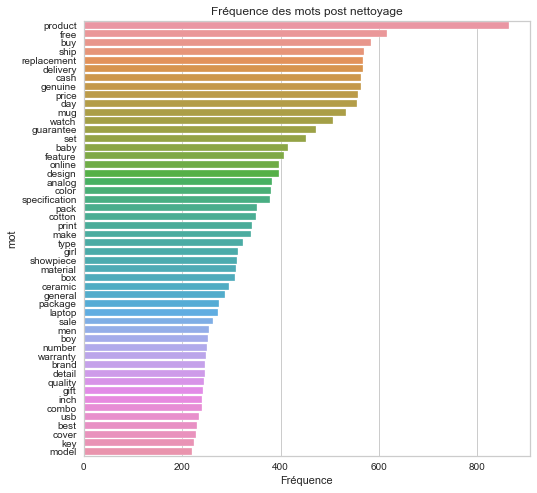

In [351]:
plt.figure(figsize =(8,8))
sns.barplot(y='Mot',x='Frequence',data=df_frequence_mot.head(50))
plt.title('Fréquence des mots post nettoyage')
plt.xlabel('Fréquence')
plt.ylabel('mot')
plt.show()

In [352]:
# Ajout des mots très fréquents
most_freq_words = df_frequence_mot.head(10)
# Ajout des mots rares
least_freq_words = df_frequence_mot[df_frequence_mot['Frequence']==1]

In [353]:
freq_words=pd.concat([most_freq_words,least_freq_words])
freq_words=pd.DataFrame(freq_words.Mot)
freq_words


Mot
119       product
201          free
192           buy
202          ship
199   replacement
...           ...
2536       stroll
722        creamy
2535     playtime
3276         navy
1167       picnic

[834 rows x 1 columns]

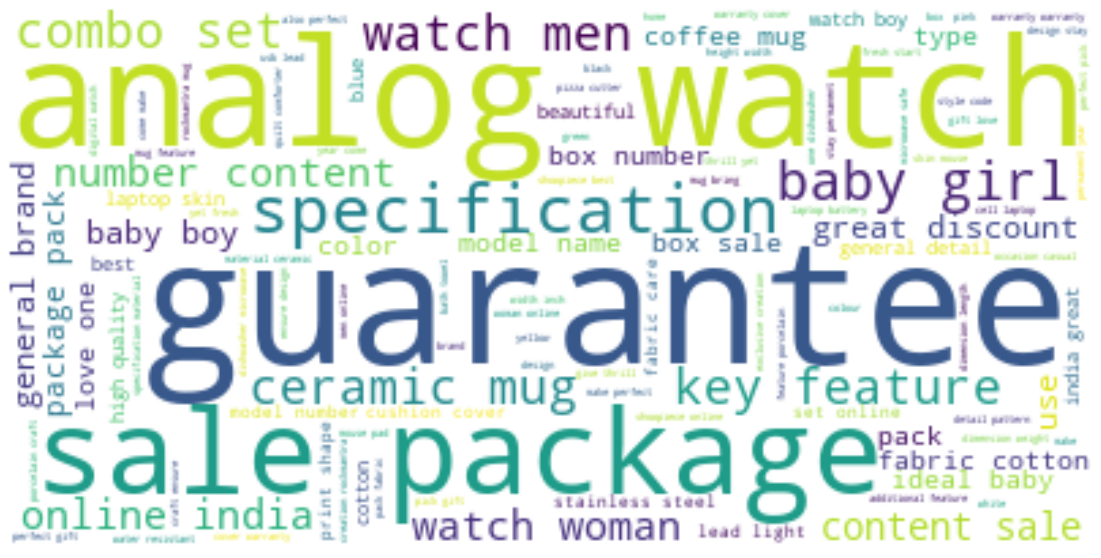

In [354]:
from wordcloud import WordCloud
corpus=data['descriptif_cleaned']
stopwords=freq_words.Mot
wc=WordCloud(background_color='white',stopwords=stopwords)
text=" ".join(map(str, corpus)) 
wc.generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

plt.show()


In [355]:
data['descriptif_final'] = data['descriptif_cleaned'].apply(lambda x: [word for word in x if word not in freq_words])
data['descriptif_final']=data['descriptif_final'].apply(lambda x: "".join(x))

In [356]:
data

product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                  product_category_tree        cat_lvl_1  \
0     ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing   
...                                                 ...              ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...        Baby Care   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                             descriptif  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1     Sathiyas Cotton Bath Towel Specifications of S...   
2     Eurospa Cotton Terry Face Towel Set Key Featur...   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker Wallman...   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048  Wallmantra Medium Vinyl Sticker Sticker Buy Wa...   
1049  Uberlyfe Large Vinyl Sticker Buy Uberlyfe Larg...   

                                     descriptif_cleaned  \
0     elegance polyester multicolor abstract eyelet ...   
1     sathiyas cotton bath towel specification sathi...   
2     eurospa cotton terry face towel set key featur...   
3     santosh royal fashion cotton print king size d...   
4     jaipur print cotton floral king size double be...   
...                                                 ...   
1045  oren empower extra large self a

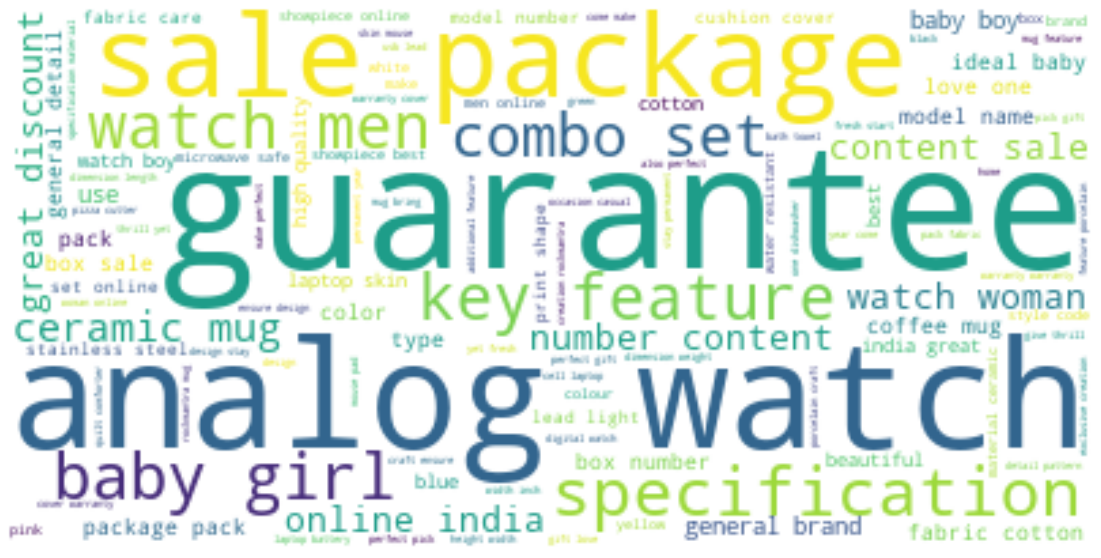

In [357]:
from wordcloud import WordCloud
corpus=data['descriptif_final']
stopwords=freq_words.Mot
wc=WordCloud(background_color='white',stopwords=stopwords)
text=" ".join(map(str, corpus)) 
wc.generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

plt.show()



# 4 - Analyse du Corpus

Après avoir réalisé les opérations de prétraitement des données textuelles, la prochaine étape consiste à les "numériser" pour pouvoir les utiliser avec des algorithmes de classification.

Nous utilisons alors les technologies de Word Embedding qui permettent de représenter des mots ou des phrases par des vecteurs de nombres réels, décrits dans un modèle vectoriel.

Il existe de nombreuses approches, nous avons testé les méthodes suivantes:

Bag of Words
Doc2vec
Bert Embedding

### Bag of words 

Cette méthode représente le texte comme un sac de mots. L'ensemble des n mots du corpus représente le vocabulaire. Le système attribue à chaque mot un index unique. Chaque paragraphe est représenté par un vecteur de longueur n, dans lequel la i-ème entrée contient le nombre d'occurrences (ou autre grandeur) du mot dans le paragraphe.
Cette approche a néanmoins l'inconvénient de perdre les notions de grammaire ainsi que l'ordre des mots.

###### CountVectorizer
La méthode CountVectorizer permet de convertir une collection de documents texte en une matrice de décomptes de mots (tokens)
voir :https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [358]:
from sklearn.feature_extraction.text import CountVectorizer

In [359]:
def matrice_(X_,vectorizer):

    # L'attribut vocabulary_ nous donne la liste des mots avec leur indice
    # On extrait les 10 premiers mots
    list_vocab = pd.DataFrame(vectorizer.vocabulary_,
                             index = range(1)).T[[0]].reset_index().sort_values('index',
                                                                         ascending=True).iloc[:10]['index'].values.tolist()
    # On retient les 12 premières lignes et les 10 premières variables (indices des mots) de la matrice
    df_X_ = pd.DataFrame(X_.toarray()).iloc[0:12,0:10]
    # On renomme les indices avec les mots correspondants
    df_X_.columns = list_vocab
    return df_X_

In [360]:
# list of text documents
corpus = data.descriptif_final
# create the transform
bow = CountVectorizer()     
# tokenize build vocab and encode document
bow_vect=bow.fit_transform(corpus)
bow_vect_features=bow.get_feature_names()
print('Dimension de la matrice:', bow_vect.toarray().shape)
matrice_(bow_vect,bow)

Dimension de la matrice: (1050, 3929)


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aaa  aapno  aari  aarika  abide  ability  able  abrasion  abroad  absolute
0     0      0     0       0      0        0     0         0       0         0
1     0      0     0       0      0        0     0         0       0         0
2     0      0     0       0      0        0     0         0       0         0
3     0      0     0       0      0        0     0         0       0         0
4     0      0     0       0      0        0     0         0       0         0
5     0      0     0       0      0        0     0         0       0         0
6     0      0     0       0      0        0     0         0       0         0
7     0      0     0       0      0        0     0         0       2         0
8     0      0     0       0      0        0     0         0       0         0
9     0      0     0       0      0        0     0         0       0         0
10    0      0     0       0      0        0     2         0       0         0
11    0      0     0       0      0        0     0         0       0         0

###### TfidfVectorizer

Fréquence du terme La fréquence « brute » d'un terme est le nombre d'occurrences de ce terme dans le document considéré (on parle de « fréquence » par abus de langage).

Fréquence inverse de document La fréquence inverse de document (inverse document frequency) est une mesure de l'importance du terme dans l'ensemble du corpus.

La matrice TF-IDF est définie pour chaque mot relativement à un corpus, comme le produit TF * IDF où:

TF = nombre de fois où le mot est dans le document / nombre de mots dans le document
IDF = nombre de documents / nombre de documents où apparaît le mot


In [361]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [362]:
# list of text documents
corpus = data.descriptif_final
# create the transform
tfidf = TfidfVectorizer()
# tokenize build vocab and encodage
tfidf_vect=tfidf.fit_transform(corpus)
tfidf_features=tfidf.get_feature_names()
print('Dimension de la matrice:', tfidf_vect.toarray().shape)
matrice_(tfidf_vect,tfidf)

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Dimension de la matrice: (1050, 3929)


aaa  aapno  aari  aarika  abide  ability     able  abrasion    abroad  \
0   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
1   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
2   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
3   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
4   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
5   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
6   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
7   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.203708   
8   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
9   0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   
10  0.0    0.0   0.0     0.0    0.0      0.0  0.14168       0.0  0.000000   
11  0.0    0.0   0.0     0.0    0.0      0.0  0.00000       0.0  0.000000   

    absolute  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        0.0  
6        0.0  
7        0.0  
8        0.0  
9        0.0  
10       0.0  
11       0.0

#### Word2Vec

Développé par Google, cet algorithme repose sur des réseaux de neurones pour apprendre les représentations vectorielles des mots. Contrairement à l'approche précédente (Bag of Words) qui ne mémorise ni la grammaire ni l'ordre des mots, Word2Vec prend en compte le contexte de telle sorte que les mots qui partagent des contextes similaires soient représentés par des vecteurs numériques proches.

In [363]:
def sent_vectorizer(sent, model):
    """Vectorisation des listes de mots"""
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model.wv[w]
            else:
                sent_vec = np.add(sent_vec, model.wv[w])
            numw+=1
        except:
            #print(f"{w} not found")
            pass
         
    return np.asarray(sent_vec) / numw

In [364]:
# reformer les doc sous forme de chaine
corpus_sw=data.descriptif_final.apply(lambda x: word_tokenize(str(x), language="english"))

In [365]:
#Word2Vec
from gensim.models import Word2Vec
modele=Word2Vec(corpus_sw,vector_size=100,window=3)

In [366]:
X_w2v=[]
for sentence in corpus_sw:
    X_w2v.append(sent_vectorizer(sentence, modele))

In [367]:
X_w2v

[array([-0.09901121,  0.27308315, -0.03373415, -0.03999131, -0.18717262,
        -0.37945312,  0.21753153,  0.52355194, -0.09469999, -0.11398841,
         0.12916918, -0.3684968 ,  0.20879959, -0.15496166,  0.04330927,
        -0.11961935,  0.04492623, -0.30632246,  0.04939909, -0.65344375,
         0.06452417, -0.18162246, -0.15429634, -0.18874654,  0.01039658,
        -0.03205268, -0.16646832, -0.48122817,  0.0362482 , -0.08874111,
        -0.07549664,  0.18791841,  0.3328806 , -0.08319511,  0.02014679,
         0.27564064,  0.04283438, -0.21231298, -0.31359765, -0.52745545,
        -0.12668286, -0.40602735,  0.11631802,  0.04552472,  0.0699226 ,
        -0.24075322,  0.03649525, -0.08584286,  0.12098645,  0.17916614,
        -0.07451124, -0.13185704, -0.12262676,  0.262849  ,  0.02012969,
         0.07576918,  0.129534  ,  0.17887883, -0.26454324,  0.26419157,
         0.14297785,  0.00542077, -0.07221782, -0.00768739, -0.46635196,
         0.10171283, -0.03489277,  0.3158298 , -0.2

In [368]:
len(X_w2v)

1050

#### Bert Embedding

What is BERT?
Bert Embedding est un modèle créé par Google. Basé sur une architecture de réseau de neurones, Bert Embedding est très performant pour le traitement automatique de la langue.

L’apprentissage passe par une première phase de pré-entraînement (assez coûteuse) qui permet au réseau de disposer d'une compréhension générale de la langue. Une seconde phase d'ajustement permet d’entraîner le réseau sur une tâche spécifique (classification de texte, analyse sémantique, analyse de sentiment...).

BERT est basé sur l’architecture de réseau Transformer. Cette architecture permet de trouver des relations entre des mots éloignés mieux que des réseaux de neurones récurrents (RNN).

Un inconvénient est la longueur des séquences qui ne doit pas dépasser 500 mots pour être performant, tant au niveau de la qualité des résultats que du temps de traitements.

Documentation:
https://huggingface.co/transformers/model_doc/bert.html
https://pypi.org/project/bert-embedding/
https://pypi.org/project/sentence-transformers/


In [369]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, Dataset
from torch import nn
from torch.nn import Module
import transformers
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM
from transformers import BertTokenizer
from transformers import BertTokenizer, BertConfig, BertPreTrainedModel, BertModel
from transformers import AlbertTokenizer, AlbertConfig, AlbertModel, AlbertPreTrainedModel
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer

print('torch:',torch.__version__)
print('transformers:',transformers.__version__)

torch: 1.11.0+cpu
transformers: 4.18.0


In [370]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

bert_ =0 ###param

if bert_ == 0:
    # Corpus
    corpus = data['descriptif_final'].values.tolist()
    # Traitement avec Bert
    X_bert = embedder.encode(corpus)

In [371]:
pd.DataFrame(X_bert).head(3)

0         1         2         3         4         5         6    \
0 -0.623512  0.422513  0.674995  0.166043  0.645063 -1.053664 -0.095414   
1 -0.512662  0.952184 -0.391943  0.355305  0.306371 -0.685473  0.507044   
2 -0.316004  0.213314  0.173386  0.440807  0.367341 -0.804056  0.302148   

        7         8         9    ...       758       759       760       761  \
0 -0.290198  0.413623 -0.935682  ... -0.274314 -1.843802 -0.554588 -0.710505   
1 -0.702450  0.370592 -0.088510  ... -0.310664 -1.259272 -1.472679 -0.408431   
2 -0.189882  0.455921 -0.230950  ...  0.096798 -0.805104 -0.994835 -0.244709   

        762       763       764       765       766       767  
0  0.179289 -0.745691 -0.275152  0.214613 -0.173203  0.175772  
1  0.410991 -0.194581 -0.217498 -0.468969 -0.128437  0.245208  
2  0.584017  0.051787 -0.313034 -0.044344 -0.463852  0.325422  

[3 rows x 768 columns]

### Modélisation LDA
L'allocation de Dirichlet latente (LDA: Latent Dirichlet Allocation) est un algorithme d'apprentissage non supervisé qui permet de décrire des ensembles d'observations par des rubriques définies par des similarités de données.

Pour utiliser le modèle LDA, nous avons besoin de connaître la fréquence d'apparition des mots dans une matrice.

Nous avons déjà produit des matrices (bag of words) avec les méthodes CountVectorizer et TfidfVectorizer.

In [372]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 7

# On créé le modèle LDA
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=50)

In [373]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

### LDA TF

In [264]:
lda.fit(bow_vect)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=7, random_state=50)

In [265]:
display_topics(lda, bow_vect_features, 20)

Topic 0:
free ship product delivery genuine cash buy replacement day guarantee watch online analog men best price showpiece set woman india
Topic 1:
baby design pack color cotton feature girl specification print box package general sale type number material fabric price polyester detail
Topic 2:
mug ceramic gift perfect coffee make design one love rockmantra material give safe price get bring specification microwave product prithish
Topic 3:
sticker wall towel vinyl apply medium large bath wallmantra decal cotton extra surface paint piece use home price uberlyfe adhesive
Topic 4:
skin oil set cream trait bowl apple shampoo oxyglow fruit type massage smooth combo lip soap product ideal macbook price
Topic 5:
crystal sing bowl energy reiki play clean sound negative vibration spf bluetooth shankh disintegrate warranty carpet product experience place benefit
Topic 6:
laptop skin warranty print shape usb pad mouse set combo multicolor inch cover power type adapter specification feature bran

In [266]:
# Trouver les topics dominants avec LDA model
# et assigner les descriptions à leurs topics respectifs avec LDA

lda_ft_results = lda.transform(bow_vect)

topics = lda_ft_results.argmax(axis=1)   # les indices du meilleur résultat de tous les produits
data['topic'] = topics

data.head(1)

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                               product_category_tree        cat_lvl_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   

                                          descriptif  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  descriptif_cleaned  \
0  elegance polyester multicolor abstract eyelet ...   

                                    descriptif_final  topic  
0  elegance polyester multicolor abstract eyelet ...      1

In [267]:
# Affichage du nombre de Produits pour chaque topic

cat_lvl_1 = data['cat_lvl_1']
topics   = data['topic']

# Dataframe associant le produit au cluster :
productCluster = pd.DataFrame({"catégorie": cat_lvl_1, "topic": topics})   # produit - topic

productCluster

catégorie  topic
0     Home Furnishing      1
1           Baby Care      1
2           Baby Care      1
3     Home Furnishing      1
4     Home Furnishing      1
...               ...    ...
1045        Baby Care      3
1046        Baby Care      3
1047        Baby Care      3
1048        Baby Care      3
1049        Baby Care      0

[1050 rows x 2 columns]

In [268]:
# Dataframe du nombre de produits par topic :
productCluster.groupby(['topic']).count()

catégorie
topic           
0            520
1            265
2             64
3             37
4             43
5             15
6            106

### LDA TF_IDF

In [269]:
lda.fit(tfidf_vect)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=7, random_state=50)

In [270]:
display_topics(lda, tfidf_features, 20)

Topic 0:
watch analog cash genuine ship delivery buy free guarantee replacement product day sticker men online woman combo set showpiece india
Topic 1:
bluetooth equinox analyzer fat story durban niko ethnic cumin malhar male doll seed learn extract ipad royal version industry kuber
Topic 2:
mug rockmantra ceramic start permanent thrill porcelain stay year microwave safe pick yet exclusive creation dishwasher ensure fresh gift one
Topic 3:
mug coffee bring perfect gift design distinctive others broadcast smile forget sip laugh freedom selection quote talk cupcake ink catchy
Topic 4:
cranberry extract fennel everytime soex sweetness flavor overwhelm arabian assort hookah taste allin excellent exporter night oil pizza lunch set
Topic 5:
agromech pine help oil pizza muscular sick catarrh cutter stimulate sore furthermore cough arthritis asthma scabies pain vapor circulation yiboo
Topic 6:
baby print skin laptop pack cotton design polyester girl eyelet set shape warranty color inch type pa

In [271]:
# Trouver les topics dominants avec LDA model
# et assigner les descriptions à leurs topics respectifs avec LDA

lda_tfidf_results = lda.transform(tfidf_vect)

topics_lda_tfidf = lda_tfidf_results.argmax(axis=1)   # les indices du meilleur résultat de tous les produits
data['topic_tfi'] = topics_lda_tfidf

data.head(1)

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                               product_category_tree        cat_lvl_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   

                                          descriptif  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  descriptif_cleaned  \
0  elegance polyester multicolor abstract eyelet ...   

                                    descriptif_final  topic  topic_tfi  
0  elegance polyester multicolor abstract eyelet ...      1          6

In [272]:
# Affichage du nombre de Produits pour chaque topic

cat_lvl_1 = data['cat_lvl_1']
topics   = data['topic_tfi']

# Dataframe associant le produit au cluster :
productCluster = pd.DataFrame({"catégorie": cat_lvl_1, "topic": topics})   # produit - topic

productCluster

catégorie  topic
0     Home Furnishing      6
1           Baby Care      6
2           Baby Care      6
3     Home Furnishing      6
4     Home Furnishing      6
...               ...    ...
1045        Baby Care      6
1046        Baby Care      6
1047        Baby Care      0
1048        Baby Care      0
1049        Baby Care      0

[1050 rows x 2 columns]

In [273]:
# Dataframe du nombre de produits par topic :
productCluster.groupby(['topic']).count()

catégorie
topic           
0            531
1              7
2             30
3             14
4              1
5              1
6            466

### NMF

#### NMF TF_IDF

In [274]:
def display_topics(model, feature_names, no_top_words):
    '''This function display topic with n key words'''
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx+1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [275]:
# optimize manually number of topics by checking their key words
n_topics=7
nmf = NMF(n_components=n_topics, random_state=42, alpha=0.1)
nmf.fit(tfidf_vect)

no_top_words = 10
display_topics(nmf, tfidf.get_feature_names(), no_top_words)

Topic 1:
watch analog men woman discount sonata india great maximum dial
Topic 2:
mug ceramic coffee printland prithish perfect gift one love get
Topic 3:
set combo guarantee replacement cash genuine ship delivery day buy
Topic 4:
baby girl dress cotton detail boy fabric print sleeve neck
Topic 5:
abstract blanket single double quilt comforter multicolor raymond floral buy
Topic 6:
laptop battery cell pavilion lapguard skin adapter warranty usb power
Topic 7:
rockmantra ceramic mug permanent thrill porcelain stay start pick creation


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [276]:
# Trouver les topics dominants avec LDA model
# et assigner les descriptions à leurs topics respectifs avec LDA

nmf_tfidf_results = nmf.transform(tfidf_vect)

topics = nmf_tfidf_results.argmax(axis=1)   # les indices du meilleur résultat de tous les produits
data['topic_nmf_tfidf'] = topics

data.head(1)

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                               product_category_tree        cat_lvl_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   

                                          descriptif  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  descriptif_cleaned  \
0  elegance polyester multicolor abstract eyelet ...   

                                    descriptif_final  topic  topic_tfi  \
0  elegance polyester multicolor abstract eyelet ...      1          6   

   topic_nmf_tfidf  
0                4

In [277]:
# Affichage du nombre de Produits pour chaque topic

cat_lvl_1 = data['cat_lvl_1']
topics   = data['topic_nmf_tfidf']

# Dataframe associant le produit au cluster :
productCluster = pd.DataFrame({"catégorie": cat_lvl_1, "topic": topics})   # produit - topic

productCluster

catégorie  topic
0     Home Furnishing      4
1           Baby Care      3
2           Baby Care      3
3     Home Furnishing      3
4     Home Furnishing      4
...               ...    ...
1045        Baby Care      5
1046        Baby Care      5
1047        Baby Care      2
1048        Baby Care      2
1049        Baby Care      2

[1050 rows x 2 columns]

In [278]:
# Dataframe du nombre de produits par topic :
productCluster.groupby(['topic']).count()

catégorie
topic           
0            155
1             60
2            342
3            199
4            115
5            132
6             47

### NMF TF

In [279]:
nmf.fit(bow_vect)

no_top_words = 10
display_topics(nmf, tfidf.get_feature_names(), no_top_words)

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic 1:
color feature pack material cover package cotton inch box product
Topic 2:
mug ceramic perfect coffee gift design make love one give
Topic 3:
product free delivery ship buy cash genuine day guarantee replacement
Topic 4:
adapter warranty replacement vaio laptop power smartpro charger product quality
Topic 5:
laptop skin print shape set pad mouse combo inch multicolor
Topic 6:
baby girl detail cotton dress fabric boy print neck sleeve
Topic 7:
watch analog men woman great india discount boy dial strap


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [280]:
# Trouver les topics dominants avec LDA model
# et assigner les descriptions à leurs topics respectifs avec LDA

nmf_tf_results = nmf.transform(bow_vect)

topics = nmf_tf_results.argmax(axis=1)   # les indices du meilleur résultat de tous les produits
data['topic_nmf_tf'] = topics

data.head(1)

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                               product_category_tree        cat_lvl_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   

                                          descriptif  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                                  descriptif_cleaned  \
0  elegance polyester multicolor abstract eyelet ...   

                                    descriptif_final  topic  topic_tfi  \
0  elegance polyester multicolor abstract eyelet ...      1          6   

   topic_nmf_tfidf  topic_nmf_tf  
0                4             0

In [281]:
# Affichage du nombre de Produits pour chaque topic

cat_lvl_1 = data['cat_lvl_1']
topics   = data['topic_nmf_tf']

# Dataframe associant le produit au cluster :
productCluster = pd.DataFrame({"catégorie": cat_lvl_1, "topic": topics})   # produit - topic

productCluster

catégorie  topic
0     Home Furnishing      0
1           Baby Care      0
2           Baby Care      0
3     Home Furnishing      0
4     Home Furnishing      0
...               ...    ...
1045        Baby Care      0
1046        Baby Care      0
1047        Baby Care      2
1048        Baby Care      2
1049        Baby Care      2

[1050 rows x 2 columns]

In [282]:
# Dataframe du nombre de produits par topic :
productCluster.groupby(['topic']).count()

catégorie
topic           
0            239
1             57
2            450
3             27
4             34
5             93
6            150

### USE (Universal Sentence Encoder)

In [374]:
import tensorflow as tens
import tensorflow_hub as hub

In [375]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

OSError: SavedModel file does not exist at: C:\Users\mehan\AppData\Local\Temp\tfhub_modules\063d866c06683311b44b4992fd46003be952409c\{saved_model.pbtxt|saved_model.pb}

In [376]:
corpus = data['descriptif_final'].values.tolist()
# Traitement avec USE
X_use = encoder(corpus)
print(X_use)

tf.Tensor(
[[-0.05334674 -0.05352823  0.00589844 ...  0.04883262  0.04014798
  -0.01675578]
 [-0.04455168 -0.04800225 -0.00789306 ...  0.02837078  0.03706142
   0.02780436]
 [-0.05292979 -0.05036514 -0.03182817 ...  0.05026793 -0.01231126
  -0.03997568]
 ...
 [ 0.00790807 -0.04393731  0.03557685 ... -0.05912261  0.05083224
  -0.06331938]
 [-0.01463912 -0.04679313  0.05576993 ...  0.01898666 -0.02194108
  -0.043372  ]
 [-0.05101909 -0.03539151  0.05263018 ...  0.01710661 -0.02330976
  -0.0215068 ]], shape=(1050, 512), dtype=float32)


In [377]:
df_use=pd.DataFrame(X_use)
df_use.to_csv('df_use.csv')

### Reduction de dimension

#### bow pca

In [379]:
print("Dimensions dataset avant réduction PCA : ", bow_vect.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_bow= pca.fit_transform(bow_vect)
print("Dimensions dataset après réduction PCA : ", pca_results_bow.shape)

Dimensions dataset avant réduction PCA :  (1050, 3929)


TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

#### L'Analyse en Composantes Principales (ACP) ne supporte pas de matrice sparse en entrée.
#### Une alternative consiste à utiliser TruncatedSVD.

#### Bag of Words (CountVectorizer) / TruncatedSVD

In [380]:
X = bow_vect

# Transformation TruncatedSVD
svd = TruncatedSVD(n_components=600, n_iter=7, random_state=50)
bow_vect_trSVD = svd.fit_transform(X)
print('Dimensions Bow_trSVD:',bow_vect_trSVD.shape)

# Variances explicatives cumulées
var_cum = svd.explained_variance_ratio_.cumsum().max()
print('Variances explicatives cumulées:',round(var_cum,2))


Dimensions Bow_trSVD: (1050, 600)
Variances explicatives cumulées: 0.99


In [381]:
# Recherche du nombre minimal de composant pour expliquer 90% de
# la variance
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0

    # Set initial number of features
    n_components = 0

    # For the explained variance of each feature:
    for explained_variance in var_ratio:

        # Add the explained variance to the total
        total_variance += explained_variance

        # Add one to the number of components
        n_components += 1

        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break

    # Return the number of components
    return n_components


In [382]:
tsvd_var_ratios = svd.explained_variance_ratio_
n_comp_mini = select_n_components(tsvd_var_ratios, 0.90)
n_comp_mini

241

In [383]:
# Réduction de dimension TruncatedSVD
tsvd_bow = TruncatedSVD(n_components=n_comp_mini,
                                   n_iter=7, random_state=50)
X_proj_tsvd_bow = tsvd_bow.fit_transform(bow_vect)
# Dataframe pour clustering
df_tsvd_bow = pd.DataFrame({'VAR1' : X_proj_tsvd_bow[:, 0],
                                       'VAR2': X_proj_tsvd_bow[:, 1],
                                       'CATEGORIE' : data['cat_lvl_1']})

In [384]:
def affiche_projections_reducdim(
        dataframe,
        X_projection,
        x_label,
        y_label,
        titre):

    # Constitution du dataframe de travail
    dataframe_work = pd.DataFrame()
    dataframe_work['VAR1'] = X_projection[:, 0]
    dataframe_work['VAR2'] = X_projection[:, 1]
    dataframe_work['CATEGORIE'] = dataframe['cat_lvl_1']

    # VIsualisation des 2 premières composantes
    plt.figure(figsize=[25, 15])

    sns.set_palette('Paired')
    sns.scatterplot(x='VAR1', y='VAR2', data=dataframe_work, hue='CATEGORIE',
                    s=100, alpha=1)
    plt.title(titre, fontsize=40)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=34)
    plt.xlabel(x_label, fontsize=34)
    plt.ylabel(y_label, fontsize=34)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(False)
    plt.show()

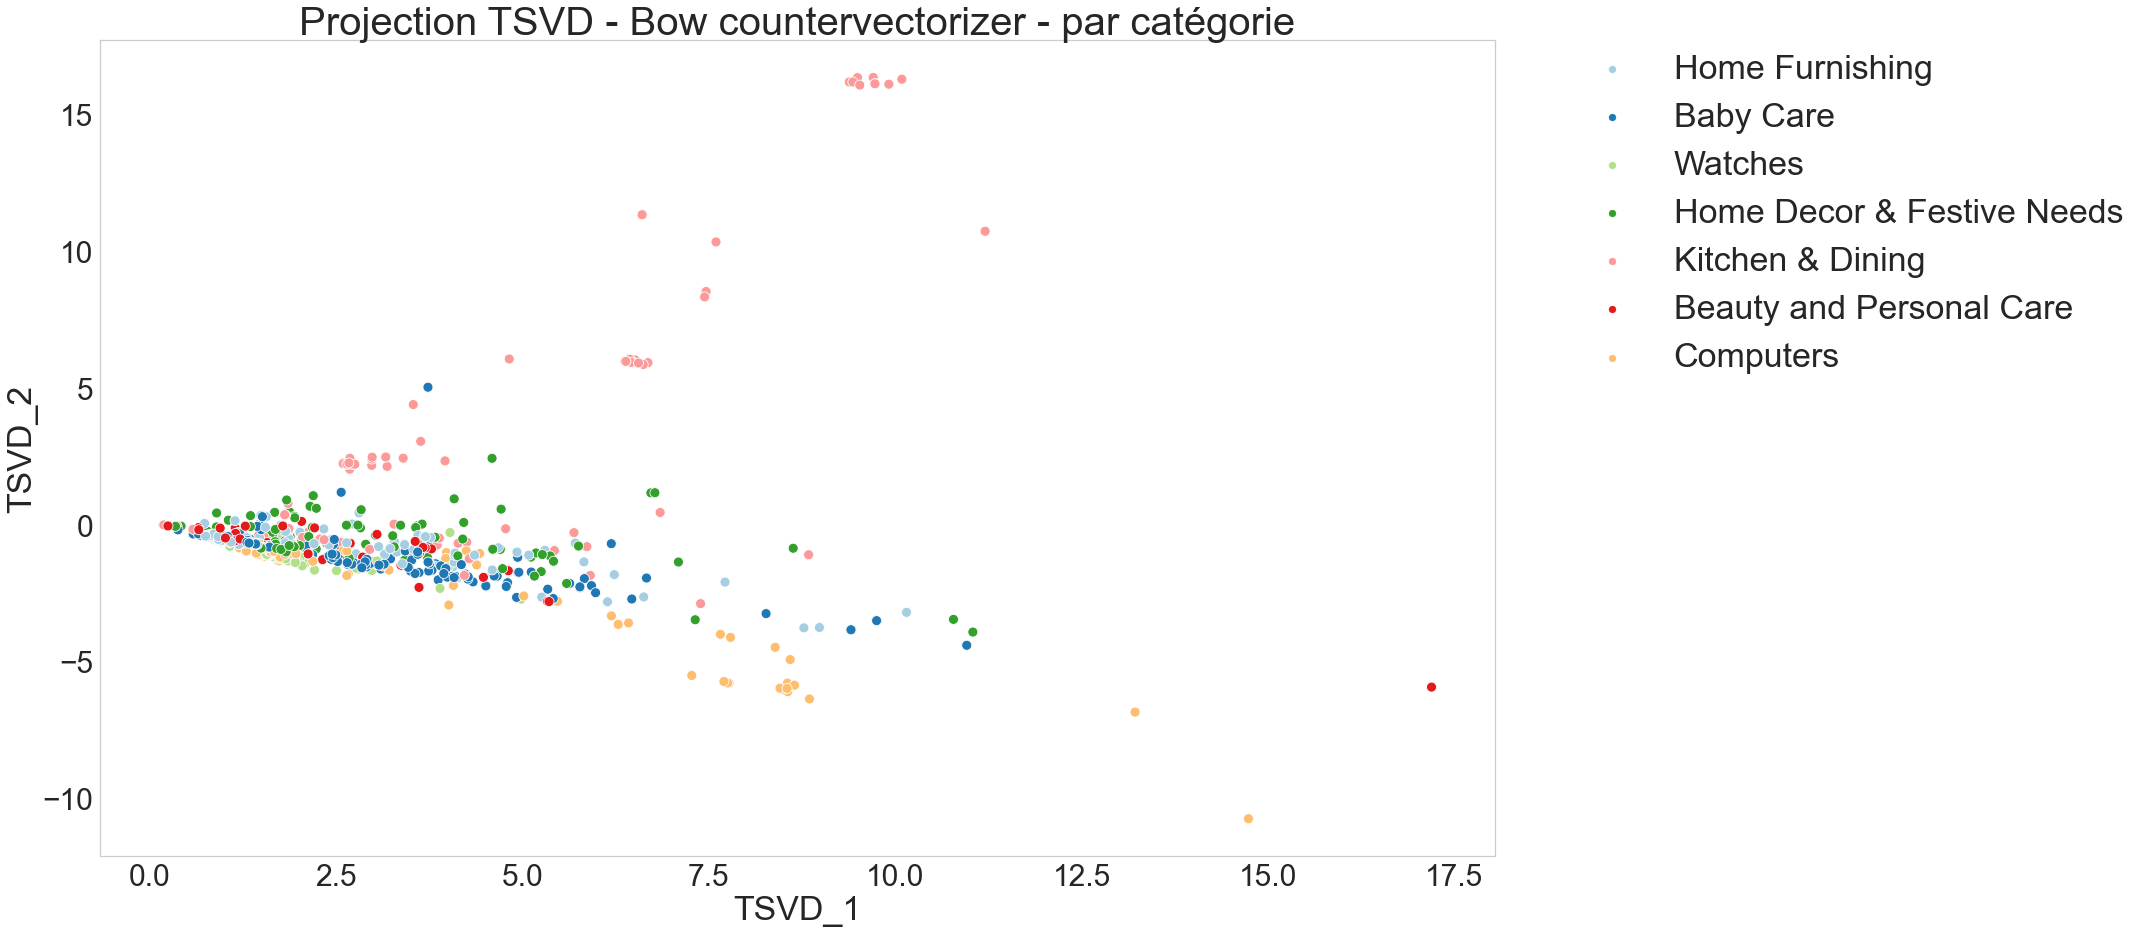

In [385]:
titre_ts = 'Projection TSVD - Bow countervectorizer'
titre_ts_1 = titre_ts + ' - par catégorie'
affiche_projections_reducdim(data, X_proj_tsvd_bow,
                                        'TSVD_1', 'TSVD_2', titre_ts_1)

In [386]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=50)
tsne_results_bow = tsne.fit_transform(X_proj_tsvd_bow)

df_tsne_bow = pd.DataFrame(tsne_results_bow[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bow["class"] = data["cat_lvl_1"]
print(df_tsne_bow.shape)

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


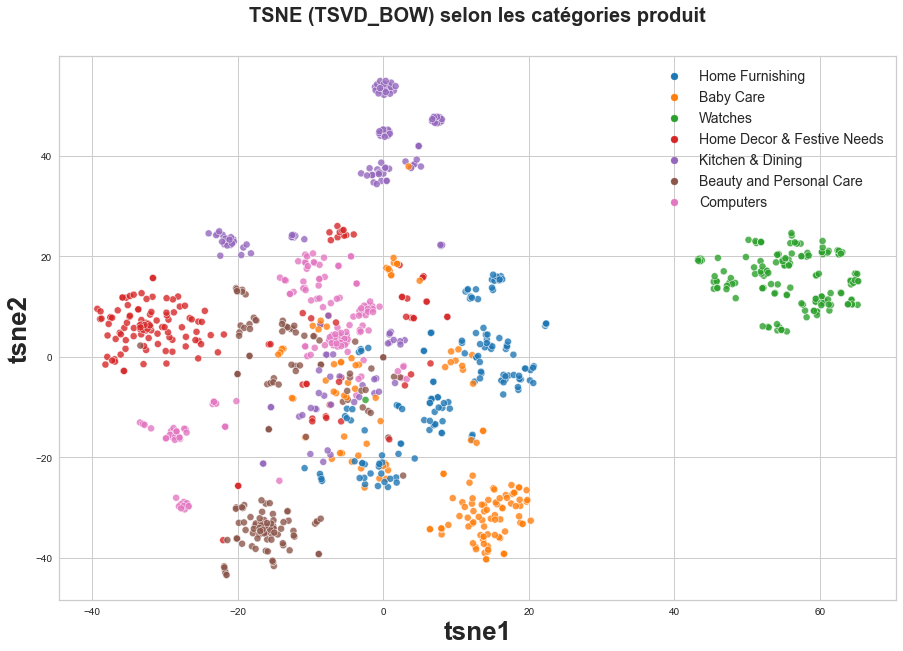

In [387]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (TSVD_BOW) selon les catégories produit', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

#### Bag of Words (TfidfVectorizer) / TruncatedSVD


In [388]:
X = tfidf_vect

# Transformation TruncatedSVD
svd = TruncatedSVD(n_components=600, n_iter=7, random_state=50)
tfidf_trSVD = svd.fit_transform(X)
print('Dimensions TF_IDF_trSVD:',tfidf_trSVD.shape)

# Variances explicatives cumulées
var_cum = svd.explained_variance_ratio_.cumsum().max()
print('Variances explicatives cumulées:',round(var_cum,2))

Dimensions TF_IDF_trSVD: (1050, 600)
Variances explicatives cumulées: 0.94


In [389]:
tsvd_var_ratios = svd.explained_variance_ratio_
n_comp_mini = select_n_components(tsvd_var_ratios, 0.90)
n_comp_mini

512

In [390]:
# Réduction de dimension TruncatedSVD
tsvd_tfidf = TruncatedSVD(n_components=n_comp_mini,
                                   n_iter=7, random_state=50)
X_proj_tsvd_tfidf = \
    tsvd_tfidf.fit_transform(tfidf_vect)
# Dataframe pour clustering
df_tsvd_tfidf = pd.DataFrame({'VAR1' : X_proj_tsvd_tfidf[:, 0],
                                       'VAR2': X_proj_tsvd_tfidf[:, 1],
                                       'CATEGORIE' : data['cat_lvl_1']})

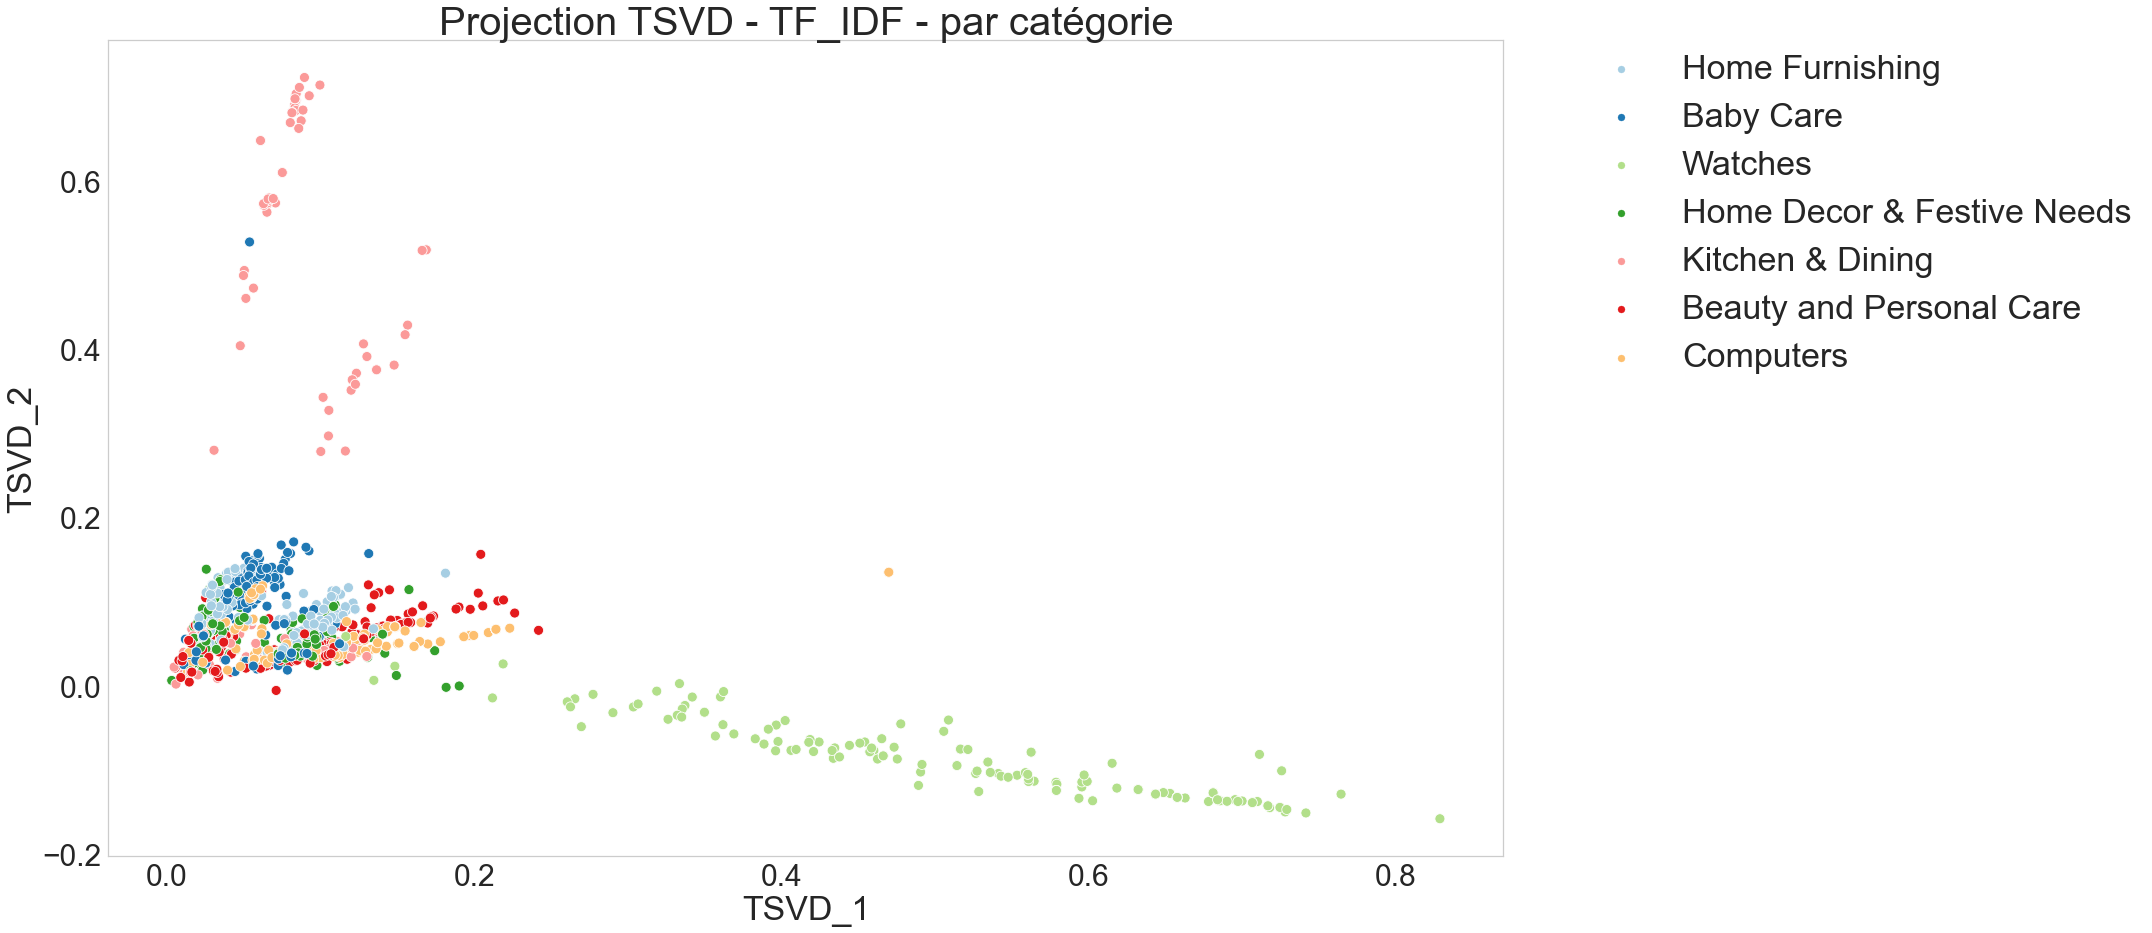

In [391]:
titre_ts = 'Projection TSVD - TF_IDF'
titre_ts_1 = titre_ts + ' - par catégorie'
affiche_projections_reducdim(data, X_proj_tsvd_tfidf,
                                        'TSVD_1', 'TSVD_2', titre_ts_1)

In [392]:
tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
tsne_results_tfidf = tsne.fit_transform(X_proj_tsvd_tfidf)

df_tsne_tfidf = pd.DataFrame(tsne_results_bow[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_tfidf["class"] = data["cat_lvl_1"]
print(df_tsne_tfidf.shape)

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


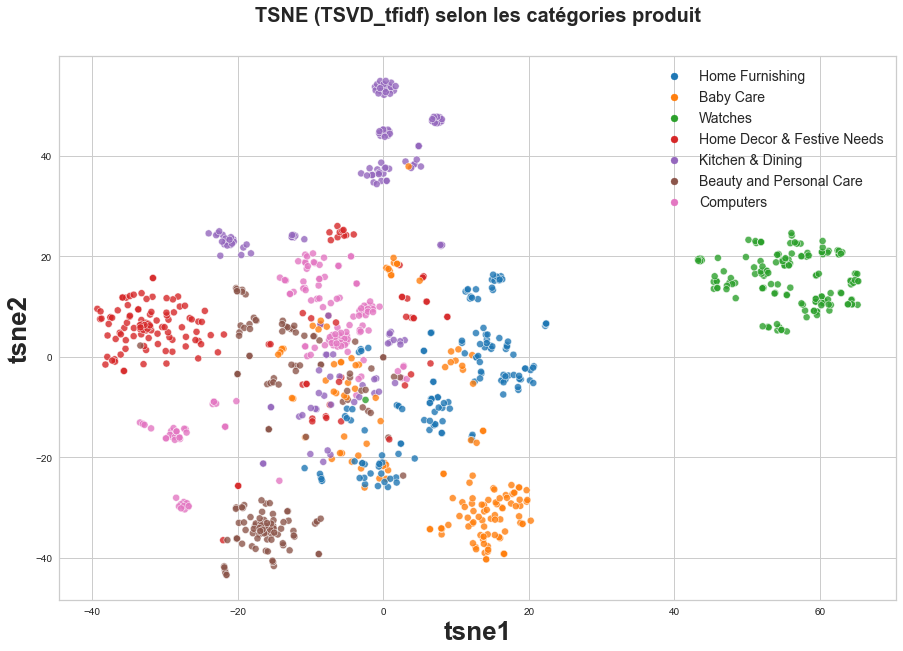

In [393]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_tfidf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (TSVD_tfidf) selon les catégories produit', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

#### Bert Embedding / TruncatedSVD

In [394]:
X = X_bert

# Transformation TruncatedSVD
svd = TruncatedSVD(n_components=600, n_iter=7, random_state=50)
X_bert_trSVD = svd.fit_transform(X)
print('Dimensions X_Bert_trSVD:',X_bert_trSVD.shape)

# Variances explicatives cumulées
var_cum = svd.explained_variance_ratio_.cumsum().max()
print('Variances explicatives cumulées:',round(var_cum,2))

Dimensions X_Bert_trSVD: (1050, 600)
Variances explicatives cumulées: 1.0


In [395]:
tsvd_var_ratios = svd.explained_variance_ratio_
n_comp_mini = select_n_components(tsvd_var_ratios, 0.99)
n_comp_mini

242

In [396]:
# Réduction de dimension TruncatedSVD
tsvd_bert = TruncatedSVD(n_components=n_comp_mini,
                                   n_iter=7, random_state=50)
X_proj_tsvd_bert = tsvd_bert.fit_transform(X_bert)
# Dataframe pour clustering
df_tsvd_X_bert = pd.DataFrame({'VAR1' : X_proj_tsvd_bert[:, 0],
                                       'VAR2': X_proj_tsvd_bert[:, 1],
                                       'CATEGORIE' : data['cat_lvl_1']})

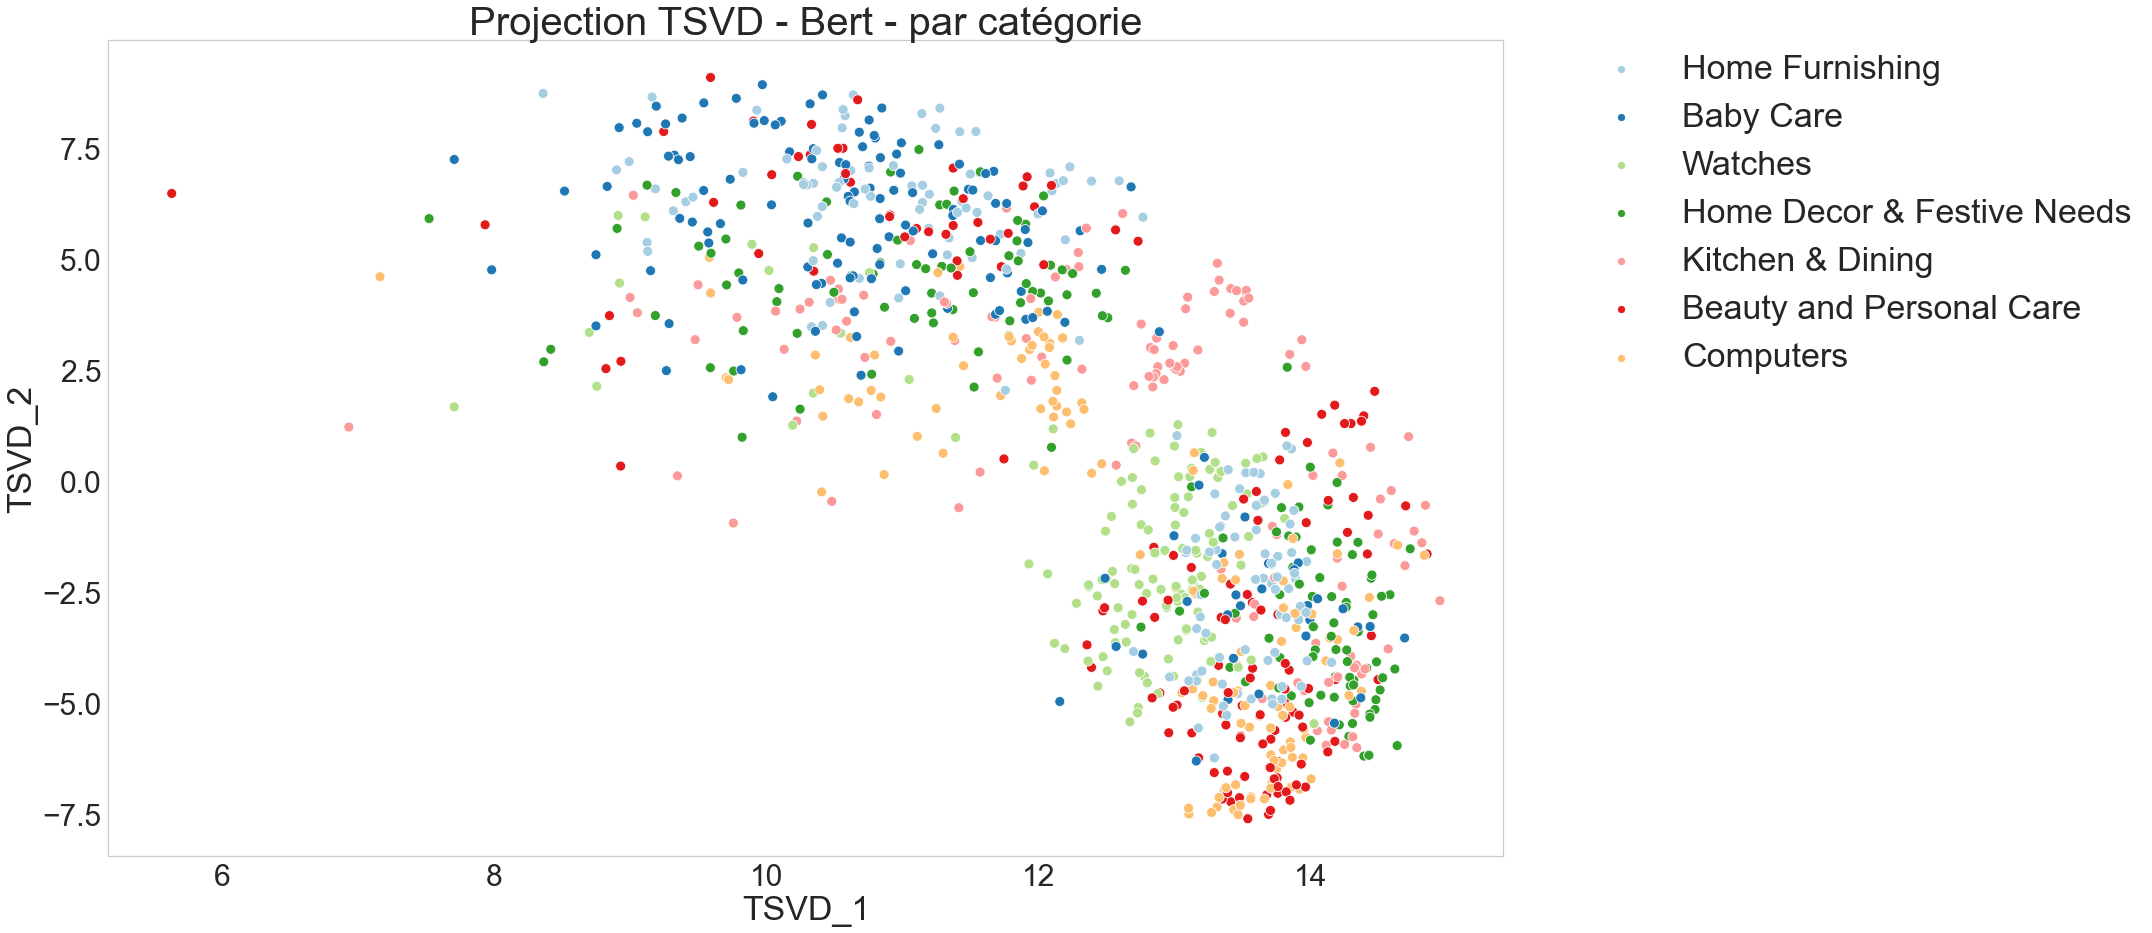

In [397]:
titre_ts = 'Projection TSVD - Bert'
titre_ts_1 = titre_ts + ' - par catégorie'
affiche_projections_reducdim(data, X_proj_tsvd_bert,
                                        'TSVD_1', 'TSVD_2', titre_ts_1)

In [398]:
tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
tsne_results_bert = tsne.fit_transform(X_proj_tsvd_bert)

df_tsne_bert = pd.DataFrame(tsne_results_bow[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bert["class"] = data["cat_lvl_1"]
print(df_tsne_bert.shape)

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


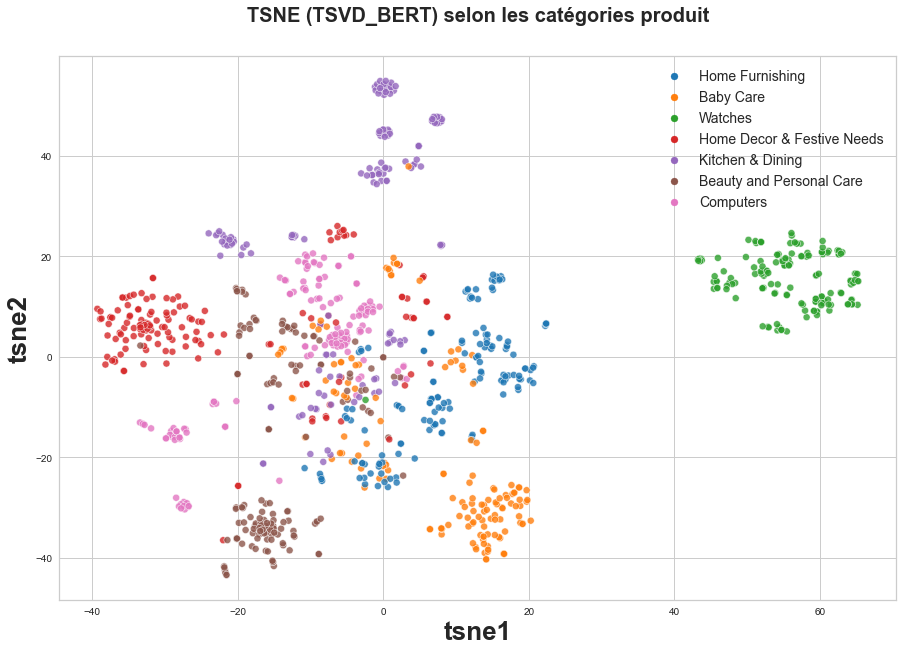

In [399]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bert, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (TSVD_BERT) selon les catégories produit', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

#### USE Embedding / TruncatedSVD

In [400]:
X = X_use

# Transformation TruncatedSVD
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=50)
X_bert_trSVD = svd.fit_transform(X)
print('Dimensions X_Bert_trSVD:',X_bert_trSVD.shape)

# Variances explicatives cumulées
var_cum = svd.explained_variance_ratio_.cumsum().max()
print('Variances explicatives cumulées:',round(var_cum,2))

Dimensions X_Bert_trSVD: (1050, 500)
Variances explicatives cumulées: 1.0


In [401]:
tsvd_var_ratios = svd.explained_variance_ratio_
n_comp_mini = select_n_components(tsvd_var_ratios, 0.99)
n_comp_mini

342

In [402]:
# Réduction de dimension TruncatedSVD
tsvd_use = TruncatedSVD(n_components=n_comp_mini,
                                   n_iter=7, random_state=50)
X_proj_tsvd_use = tsvd_bert.fit_transform(X_use)
# Dataframe pour clustering
df_tsvd_X_use = pd.DataFrame({'VAR1' : X_proj_tsvd_use[:, 0],
                                       'VAR2': X_proj_tsvd_use[:, 1],
                                       'CATEGORIE' : data['cat_lvl_1']})

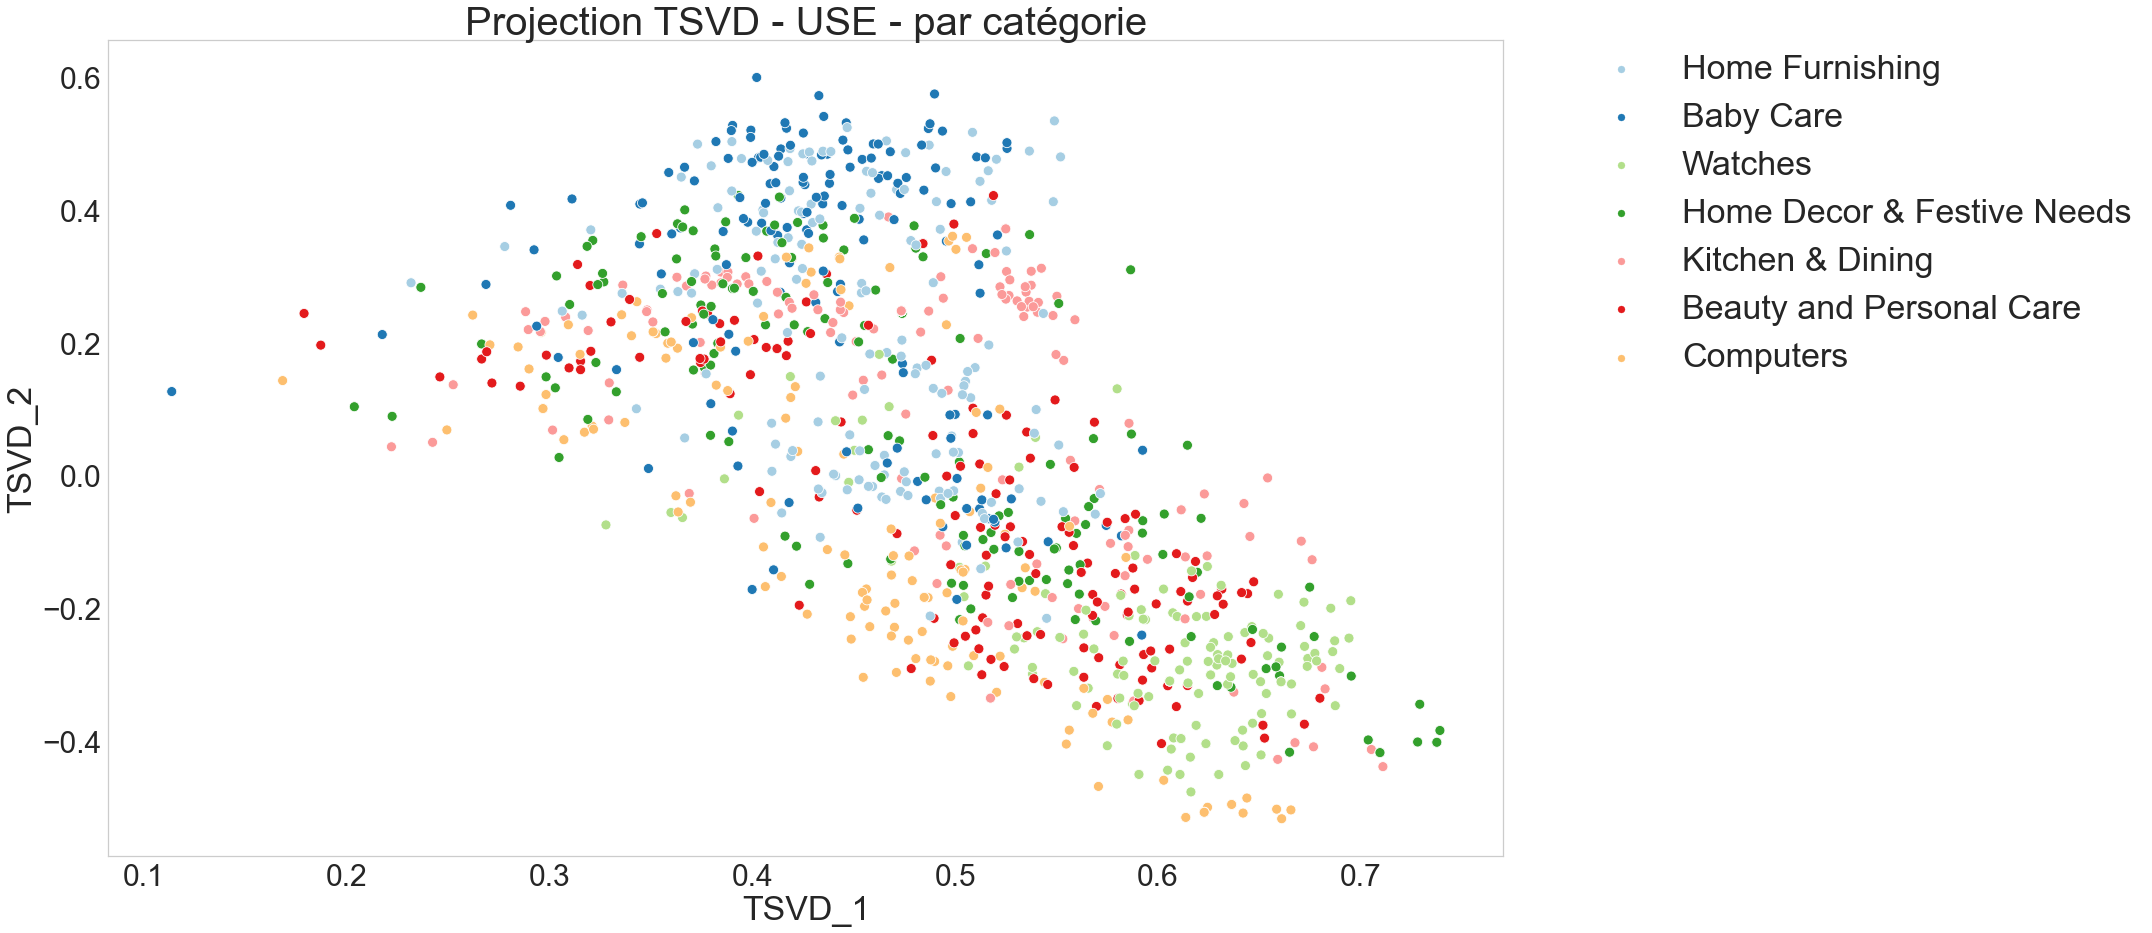

In [403]:
titre_ts = 'Projection TSVD - USE'
titre_ts_1 = titre_ts + ' - par catégorie'
affiche_projections_reducdim(data, X_proj_tsvd_use,
                                        'TSVD_1', 'TSVD_2', titre_ts_1)

In [404]:
tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
tsne_results_use = tsne.fit_transform(X_proj_tsvd_use)

df_tsne_use = pd.DataFrame(tsne_results_use[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_use["class"] = data["cat_lvl_1"]
print(df_tsne_use.shape)

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


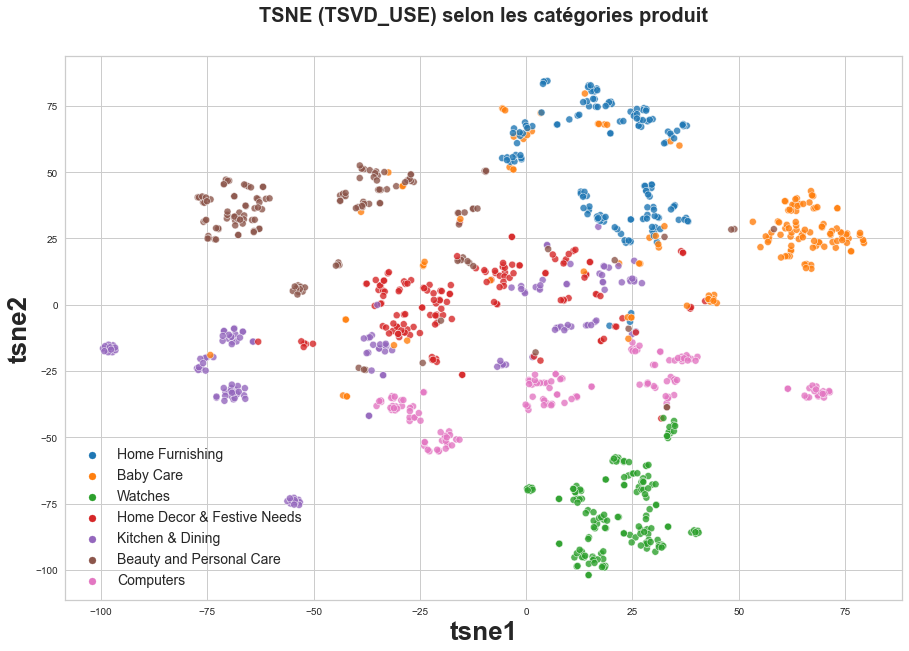

In [405]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_use, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (TSVD_USE) selon les catégories produit', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

##  5-Clusturing  Kmeans

In [406]:
def clusters_scores(X,labels1, labels2, name_col):
    '''Return a dataframe of clustering scores :
    Homogeneity, Completeness, V-measure, ARI
    Args:
    'labels1 : list
    labels2 : list
    name_col : string
    '''
    homo = metrics.homogeneity_score(labels1, labels2)
    comp = metrics.completeness_score(labels1, labels2)
    v_mea = metrics.v_measure_score(labels1, labels2)
    ari = metrics.adjusted_rand_score(labels1, labels2)
    sil=silhouette_score(X,km.labels_,metric="euclidean")
    return  pd.DataFrame({name_col: [homo,
                              comp,
                              v_mea,
                              ari,sil]},
                              index=['Homogeneity',
                                     'Completeness',
                                     'V_measure','ARI','sil_scor'],
                              dtype='float64')

### SVD-TF-KMEANS

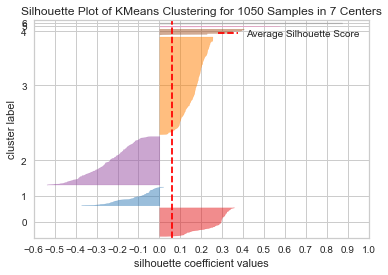

Le score de silhouette est 0.06095965058105341


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


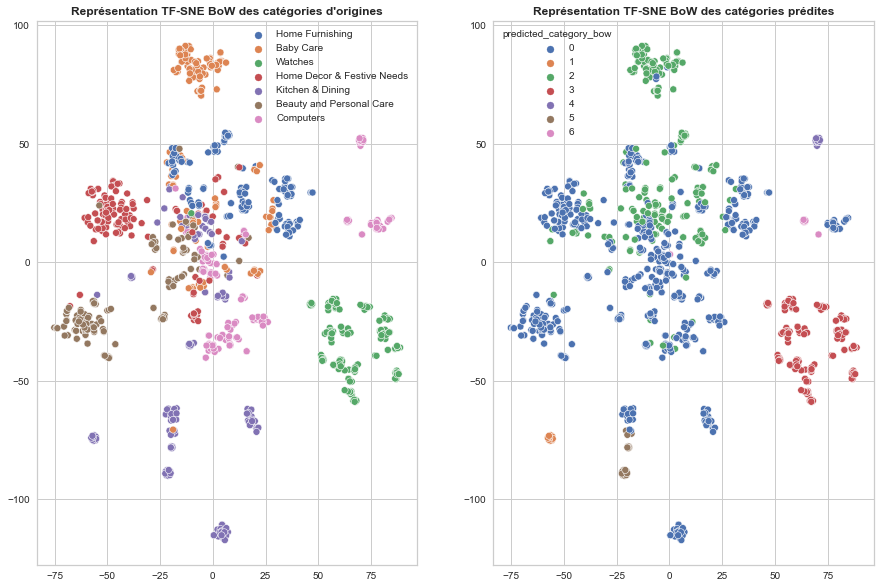

In [407]:
labels_true = data['cat_lvl_1'].values
km = KMeans(n_clusters=7)

#bow

visualizer=SilhouetteVisualizer(km)
visualizer.fit(X_proj_tsvd_bow)
visualizer.poof()
sil = silhouette_score(X_proj_tsvd_bow,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)


km_bow=km.fit(X_proj_tsvd_bow) 
labels_bow = km.labels_
#rajouter les nouveaux labels au dataframe 
data['predicted_category_bow'] =labels_bow
predicted_clusters_bow = data['predicted_category_bow'] 

tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
T= tsne.fit_transform(X_proj_tsvd_bow)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE BoW des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=predicted_clusters_bow,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE BoW des catégories prédites", fontweight='bold')
plt.show()


svd_tf_km_scores = clusters_scores(T,labels_bow, labels_true, 'svd_tf_Kmeans')





### TSNE_TF_KMeans

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


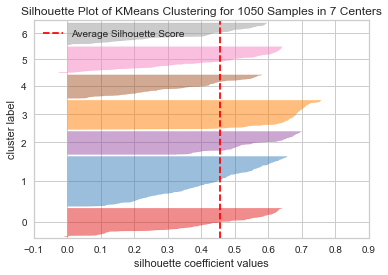

Le score de silhouette est 0.45526472


C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


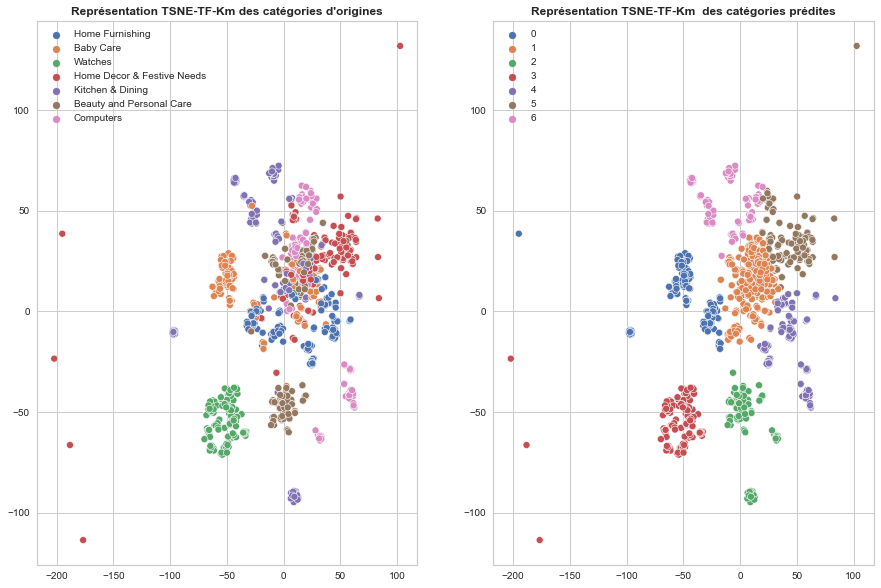

In [297]:
# Réduction de dimension par t-SNE

tsne_results_tf = tsne.fit_transform(bow_vect) 
T=tsne_results_tf
# KMeans sur les 7 catégories
km_tf=km.fit(T)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(T)
visualizer.poof()
sil = silhouette_score(T,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)


labels_tf = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_tf'] =labels_tf
predicted_clusters_tf = data['predicted_category_tf'] 


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TSNE-TF-Km des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=labels_tf,legend='full', palette='deep')
ax.set_title("Représentation TSNE-TF-Km  des catégories prédites", fontweight='bold')
plt.show()

tsne_tf_km_scores = clusters_scores(T,labels_tf, labels_true, 'tsne_tf_Kmeans')

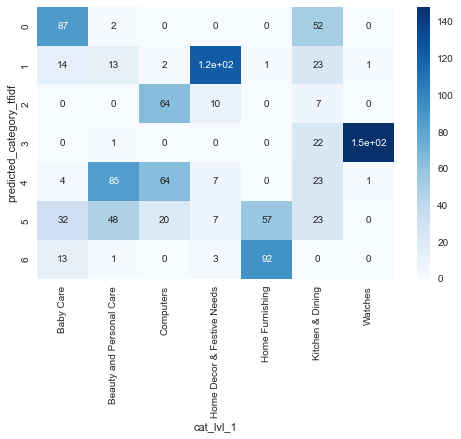

In [298]:
plt.figure(figsize=(8, 5))
sns.heatmap(pd.crosstab(data['predicted_category_tfidf'], data['cat_lvl_1']),
            annot=True,
            cmap="Blues")
plt.show()

### SVD_TFIDF_KMeans

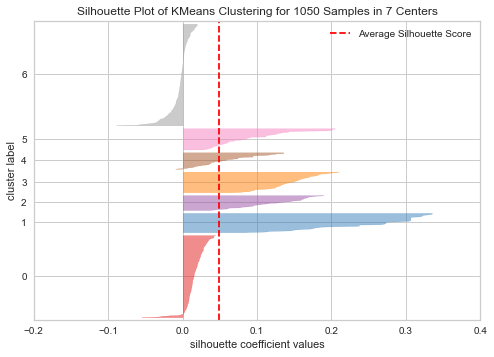

Le score de silhouette est 0.04850592457253448


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


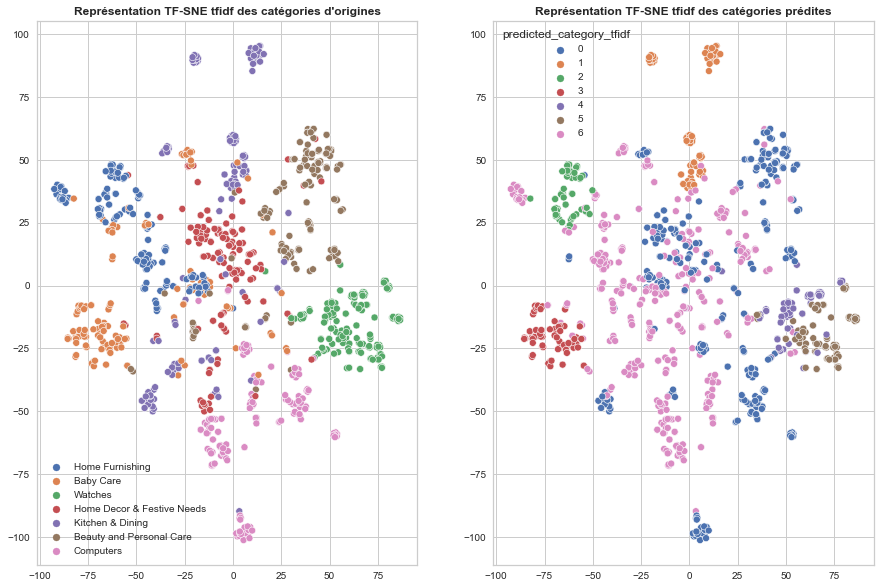

In [126]:
# tfidf
km_tfidf=km.fit(X_proj_tsvd_tfidf)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(X_proj_tsvd_tfidf)
visualizer.poof()
sil = silhouette_score(X_proj_tsvd_tfidf,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

labels_tfidf = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_tfidf'] =labels_tfidf
predicted_clusters_tfidf = data['predicted_category_tfidf'] 

tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
T= tsne.fit_transform(X_proj_tsvd_tfidf)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE tfidf des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=predicted_clusters_tfidf,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE tfidf des catégories prédites", fontweight='bold')
plt.show()

svd_tfidf_km_scores = clusters_scores(T,labels_tfidf, labels_true, 'svd_tfidf_Kmeans')



### TSNE_TFIDF_KMeans

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


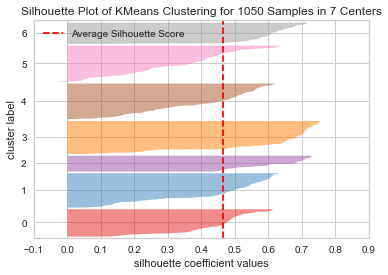

Le score de silhouette est 0.46387497


C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


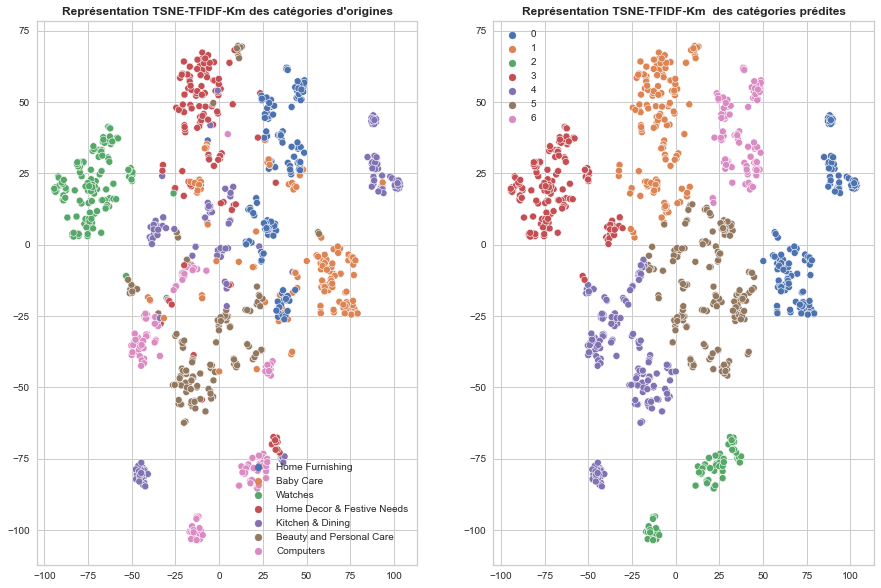

In [288]:
# Réduction de dimension par t-SNE

tsne_results_tfidf = tsne.fit_transform(tfidf_vect) 
T=tsne_results_tfidf
# KMeans sur les 7 catégories
km_tfidf=km.fit(T)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(T)
visualizer.poof()
sil = silhouette_score(T,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)


labels_tfidf = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_tfidf'] =labels_tfidf
predicted_clusters_tfidf = data['predicted_category_tfidf'] 


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TSNE-TFIDF-Km des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=labels_tfidf,legend='full', palette='deep')
ax.set_title("Représentation TSNE-TFIDF-Km  des catégories prédites", fontweight='bold')
plt.show()

tsne_tfidf_km_scores = clusters_scores(T,labels_tfidf, labels_true, 'tsne_tfidf_Kmeans')

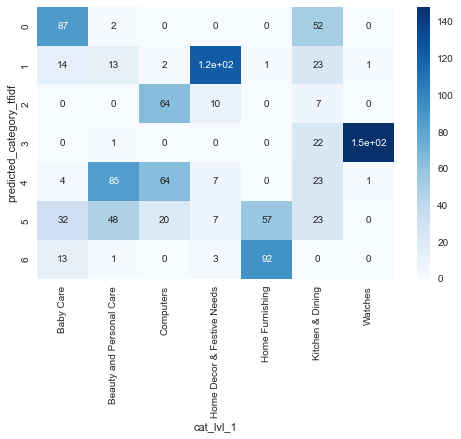

In [293]:

plt.figure(figsize=(8, 5))
sns.heatmap(pd.crosstab(data['predicted_category_tfidf'], data['cat_lvl_1']),
            annot=True,
            cmap="Blues")
plt.show()


In [290]:

data.groupby('predicted_category_tfidf')['cat_lvl_1'].value_counts().to_frame()

cat_lvl_1
predicted_category_tfidf cat_lvl_1                            
0                        Baby Care                          87
                         Kitchen & Dining                   52
                         Beauty and Personal Care            2
1                        Home Decor & Festive Needs        123
                         Kitchen & Dining                   23
                         Baby Care                          14
                         Beauty and Personal Care           13
                         Computers                           2
                         Home Furnishing                     1
                         Watches                             1
2                        Computers                          64
                         Home Decor & Festive Needs         10
                         Kitchen & Dining                    7
3                        Watches                           148
                         Kitchen & Dining                   22
                         Beauty and Personal Care            1
4                        Beauty and Personal Care           85
                         Computers                          64
                         Kitchen & Dining                   23
                         Home Decor & Festive Needs          7
                         Baby Care                           4
                         Watches                             1
5                        Home Furnishing                    57
                         Beauty and Personal Care           48
                         Baby Care                          32
                         Kitchen & Dining                   23
                         Computers                          20
                         Home Decor & Festive Needs          7
6                        Home Furnishing                    92
                         Baby Care                          13
                         Home Decor & Festive Needs          3
                         Beauty and Personal Care            1

In [187]:
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

### SVD BERT KMeans

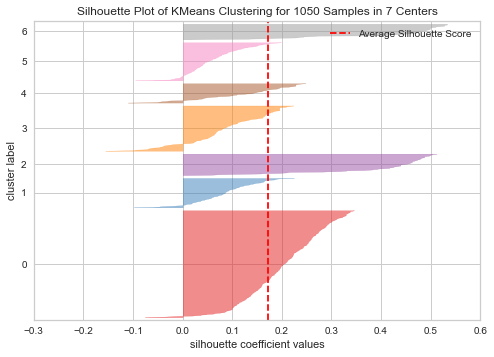

Le score de silhouette est 0.17113139


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


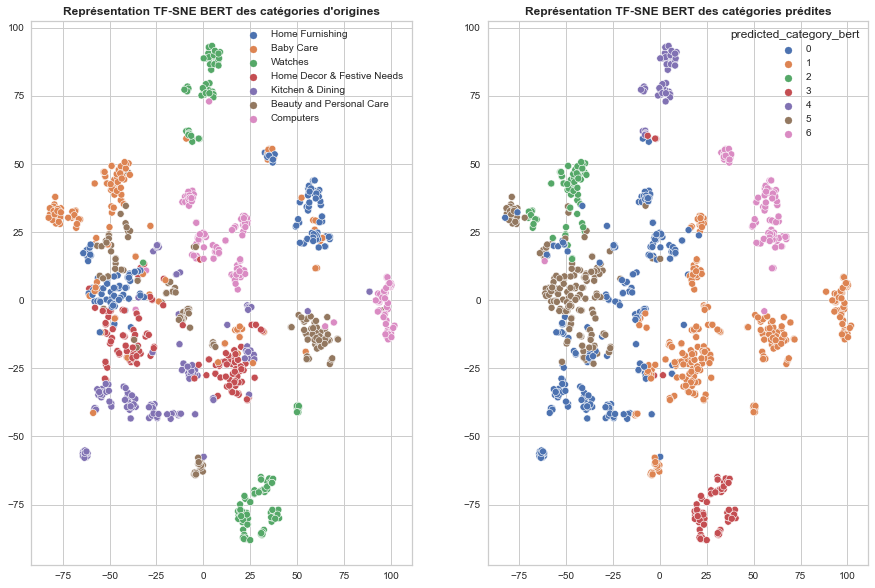

In [139]:
# Bert
visualizer=SilhouetteVisualizer(km)
visualizer.fit(X_proj_tsvd_bert)
visualizer.poof()
sil = silhouette_score(X_proj_tsvd_bert,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

km_bert=km.fit(X_proj_tsvd_bert)
labels_bert = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_bert'] =labels_bert
predicted_clusters_bert = data['predicted_category_bert'] 

tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=23)
T= tsne.fit_transform(X_proj_tsvd_bert)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE BERT des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=predicted_clusters_bert,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE BERT des catégories prédites", fontweight='bold')
plt.show()
svd_bert_km_scores = clusters_scores(T,labels_bert, labels_true, 'svd_bert_Kmeans')



### TSNE BERT KMeans

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


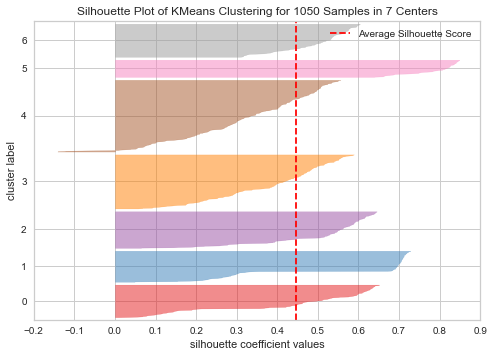

Le score de silhouette est 0.44559866


C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


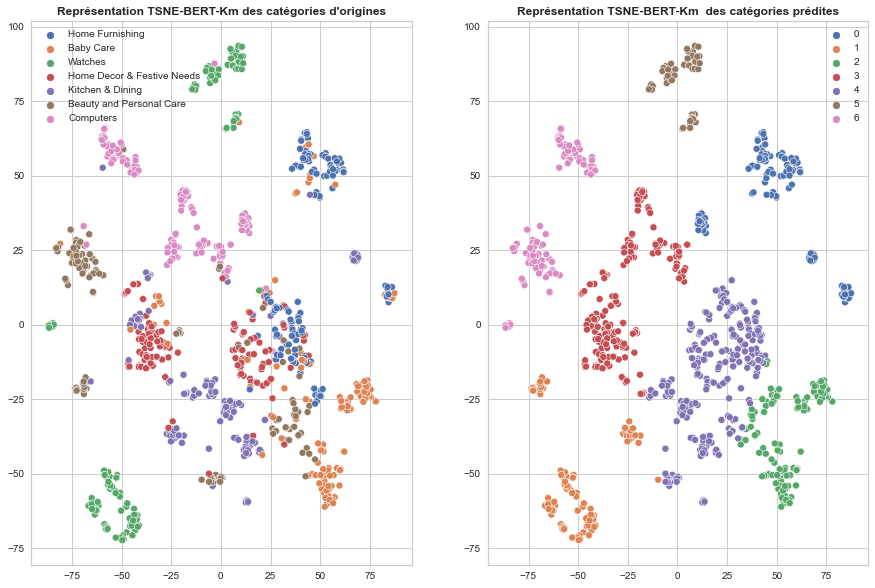

In [140]:
# Réduction de dimension par t-SNE

tsne_results_bert = tsne.fit_transform(X_bert) 
T=tsne_results_bert
# KMeans sur les 7 catégories
km_tfidf=km.fit(T)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(T)
visualizer.poof()
sil = silhouette_score(T,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)


labels_bert = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_bert'] =labels_bert
predicted_clusters_bert = data['predicted_category_bert'] 


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TSNE-BERT-Km des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=labels_bert,legend='full', palette='deep')
ax.set_title("Représentation TSNE-BERT-Km  des catégories prédites", fontweight='bold')
plt.show()

tsne_bert_km_scores = clusters_scores(T,labels_bert, labels_true, 'tsne_bert_Kmeans')

#### SVD USE Kmeans

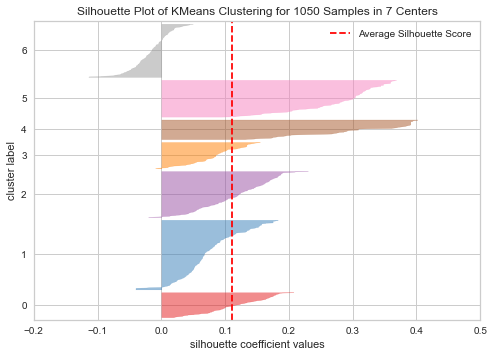

Le score de silhouette est 0.1113619


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


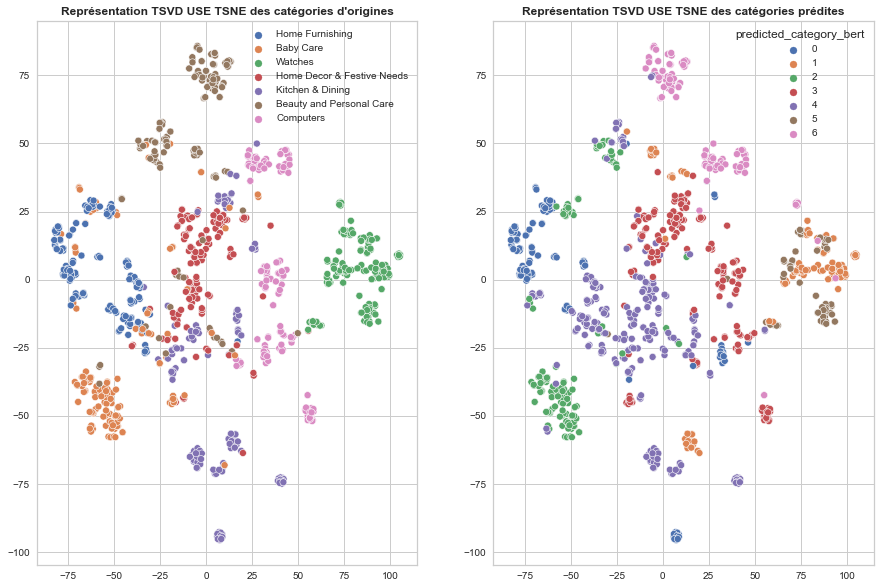

In [145]:
# USE
visualizer=SilhouetteVisualizer(km)
visualizer.fit(X_proj_tsvd_use)
visualizer.poof()
sil = silhouette_score(X_proj_tsvd_use,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

km_bert=km.fit(X_proj_tsvd_use)
labels_use = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_use'] =labels_use
predicted_clusters_use = data['predicted_category_use'] 

tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=23)
T= tsne.fit_transform(X_proj_tsvd_use)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TSVD USE TSNE des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=predicted_clusters_bert,legend='full', palette='deep')
ax.set_title("Représentation TSVD USE TSNE des catégories prédites", fontweight='bold')
plt.show()
svd_use_km_scores = clusters_scores(T,labels_bert, labels_true, 'svd_bert_Kmeans')


#### TSNE USE Kmeans

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


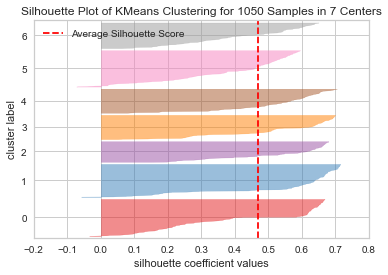

Le score de silhouette est 0.46994495


C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


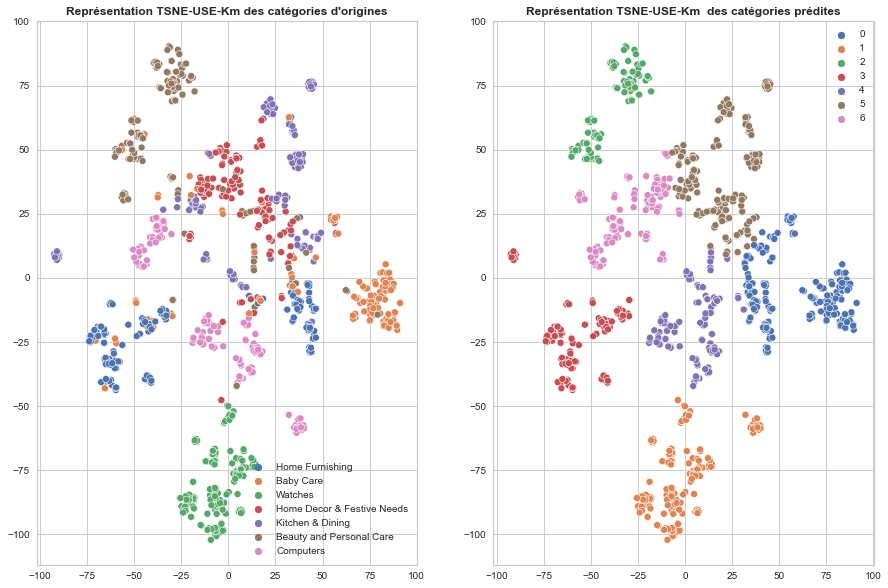

In [408]:
# Réduction de dimension par t-SNE

tsne_results_use = tsne.fit_transform(X_use) 
T=tsne_results_use
# KMeans sur les 7 catégories
km_tfidf=km.fit(T)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(T)
visualizer.poof()
sil = silhouette_score(T,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)


labels_use = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_use'] =labels_use
predicted_clusters_use = data['predicted_category_use'] 


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TSNE-USE-Km des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=labels_use,legend='full', palette='deep')
ax.set_title("Représentation TSNE-USE-Km  des catégories prédites", fontweight='bold')
plt.show()

tsne_use_km_scores = clusters_scores(T,labels_use, labels_true, 'tsne_use_Kmeans')

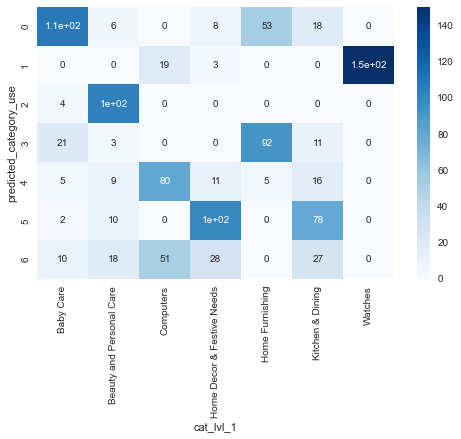

In [410]:
plt.figure(figsize=(8, 5))
sns.heatmap(pd.crosstab(data['predicted_category_use'], data['cat_lvl_1']),
            annot=True,
            cmap="Blues")
plt.show()


In [411]:
data.groupby('predicted_category_use')['cat_lvl_1'].value_counts().to_frame()

cat_lvl_1
predicted_category_use cat_lvl_1                            
0                      Baby Care                         108
                       Home Furnishing                    53
                       Kitchen & Dining                   18
                       Home Decor & Festive Needs          8
                       Beauty and Personal Care            6
1                      Watches                           150
                       Computers                          19
                       Home Decor & Festive Needs          3
2                      Beauty and Personal Care          104
                       Baby Care                           4
3                      Home Furnishing                    92
                       Baby Care                          21
                       Kitchen & Dining                   11
                       Beauty and Personal Care            3
4                      Computers                          80
                       Kitchen & Dining                   16
                       Home Decor & Festive Needs         11
                       Beauty and Personal Care            9
                       Baby Care                           5
                       Home Furnishing                     5
5                      Home Decor & Festive Needs        100
                       Kitchen & Dining                   78
                       Beauty and Personal Care           10
                       Baby Care                           2
6                      Computers                          51
                       Home Decor & Festive Needs         28
                       Kitchen & Dining                   27
                       Beauty and Personal Care           18
                       Baby Care                          10

### LDA_TF Kmeans

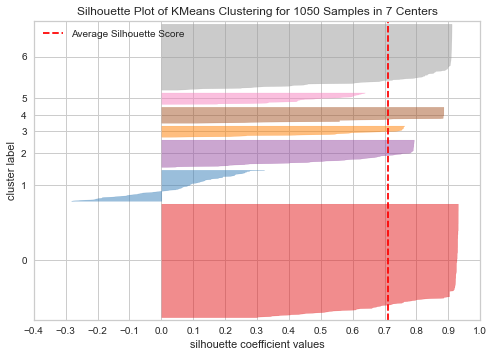

Le score de silhouette est 0.7105313466092352


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


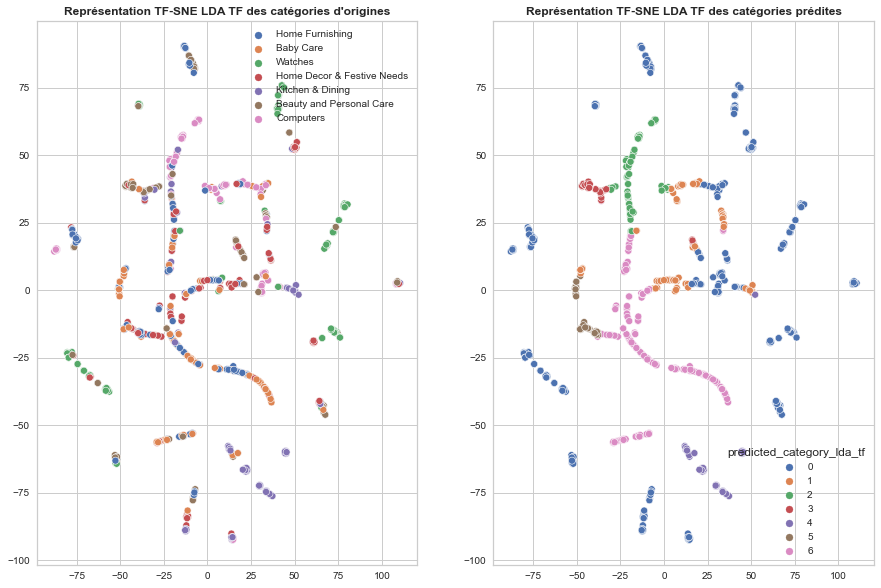

In [147]:
# LDA TF
km_lda=km.fit(lda_ft_results)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(lda_ft_results)
visualizer.poof()
sil = silhouette_score(lda_ft_results,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

labels_lda_ft = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_lda_tf'] =labels_lda_ft
predicted_clusters_lda = data['predicted_category_lda_tf'] 

tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
T= tsne.fit_transform(lda_ft_results)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE LDA TF des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=predicted_clusters_lda,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE LDA TF des catégories prédites", fontweight='bold')
plt.show()

lda_tf_km_scores = clusters_scores(T,labels_lda_ft, labels_true, 'lda_tf_Kmeans')

### LDA_TFIDF KMeans

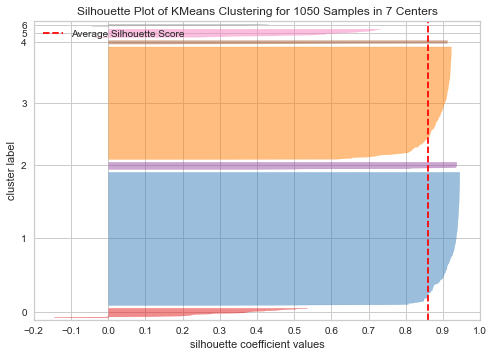

Le score de silhouette est 0.860259020251491


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


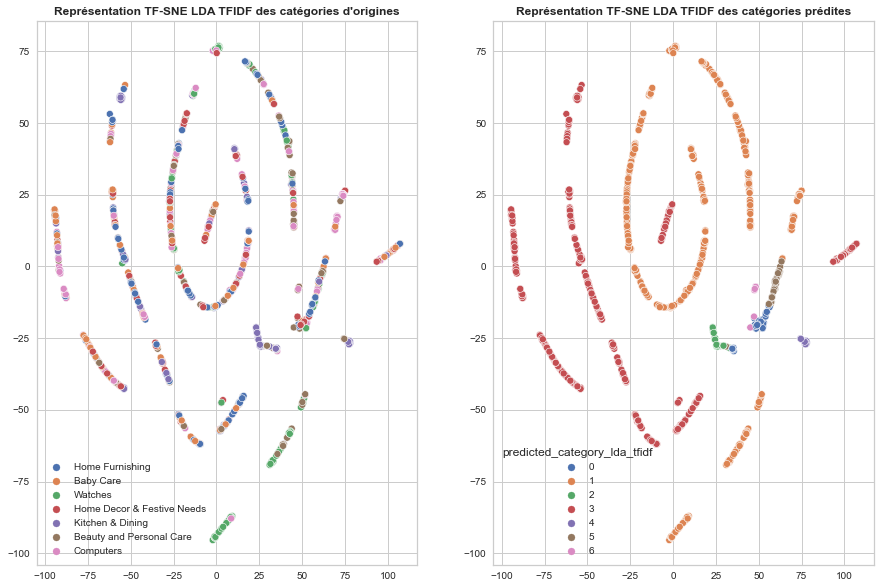

In [148]:
# LDA TFIDF
km_lda=km.fit(lda_tfidf_results)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(lda_tfidf_results)
visualizer.poof()
sil = silhouette_score(lda_tfidf_results,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

labels_lda_tfidf = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_lda_tfidf'] =labels_lda_tfidf
predicted_clusters_lda_tfidf = data['predicted_category_lda_tfidf'] 

tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
T= tsne.fit_transform(lda_tfidf_results)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE LDA TFIDF des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=predicted_clusters_lda_tfidf,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE LDA TFIDF des catégories prédites", fontweight='bold')
plt.show()

lda_tfidf_km_scores = clusters_scores(T,labels_lda_tfidf, labels_true, 'lda_tfidf_Kmeans')

### NMF_TF KMeans

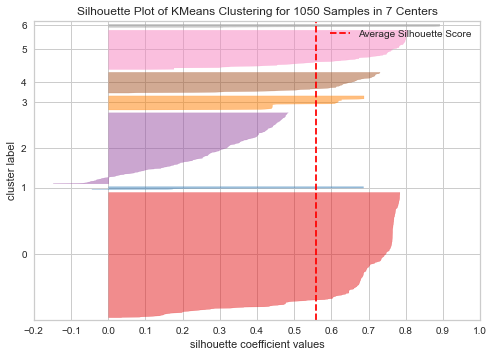

Le score de silhouette est 0.5586200033387997


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


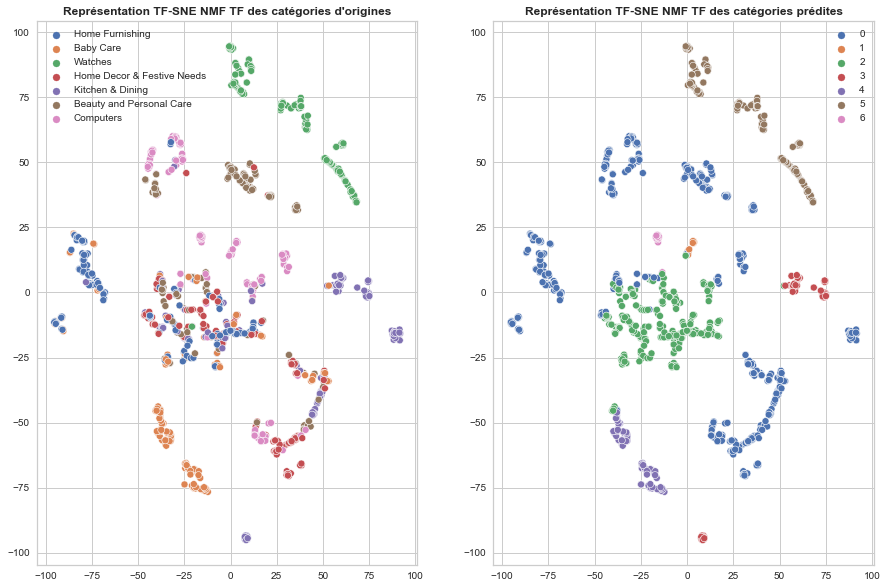

In [149]:
# NMF TF
km_lda=km.fit(nmf_tf_results)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(nmf_tf_results)
visualizer.poof()
sil = silhouette_score(nmf_tf_results,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

labels_nmf_tf = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_nmf_tf'] =labels_nmf_tf
predicted_clusters_nmf_tf = data['predicted_category_nmf_tf'] 

tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
T= tsne.fit_transform(nmf_tf_results)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE NMF TF des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=labels_nmf_tf,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE NMF TF des catégories prédites", fontweight='bold')
plt.show()

nmf_tf_km_scores = clusters_scores(T,labels_nmf_tf, labels_true, 'nmf_tf_Kmeans')

### NMF_TF KMeans

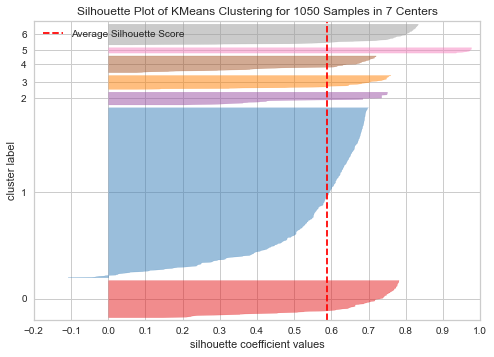

Le score de silhouette est 0.5867739731449031


C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


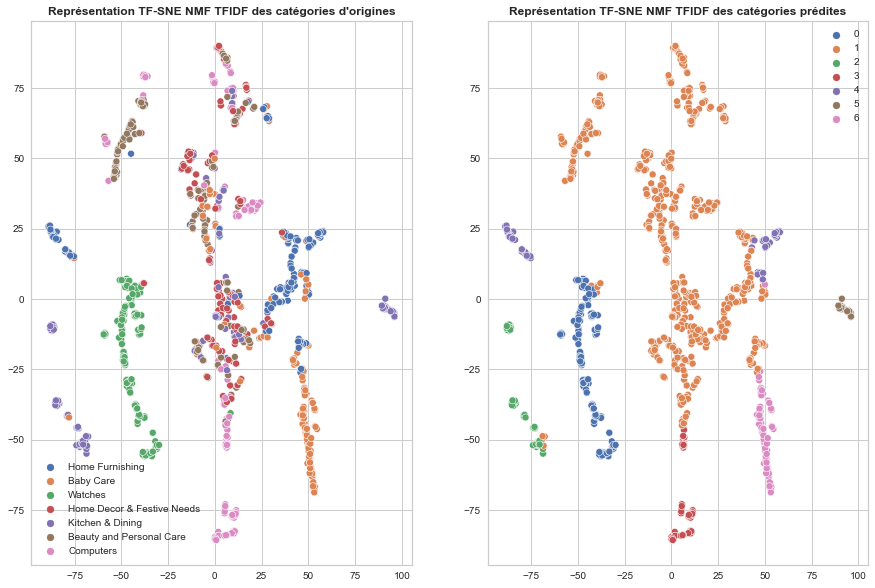

In [150]:
# NMF TFIDF
km_lda=km.fit(nmf_tfidf_results)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(nmf_tfidf_results)
visualizer.poof()
sil = silhouette_score(nmf_tfidf_results,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

labels_nmf_tfidf = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_nmf_tfidf'] =labels_nmf_tfidf
predicted_clusters_nmf_tfidf = data['predicted_category_nmf_tfidf'] 

tsne = manifold.TSNE(n_components=2, perplexity=10, 
                     n_iter=2000, init='random', random_state=50)
T= tsne.fit_transform(nmf_tfidf_results)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE NMF TFIDF des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=labels_nmf_tfidf,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE NMF TFIDF des catégories prédites", fontweight='bold')
plt.show()

nmf_tfidf_km_scores = clusters_scores(T,labels_nmf_tfidf, labels_true, 'nmf_tfidf_Kmeans')

### TSNE_W2V Kmeans

C:\Users\mehan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


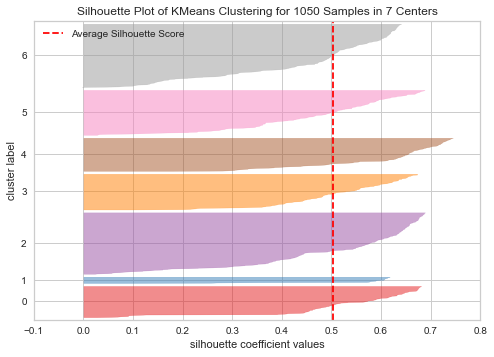

Le score de silhouette est 0.502902


C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


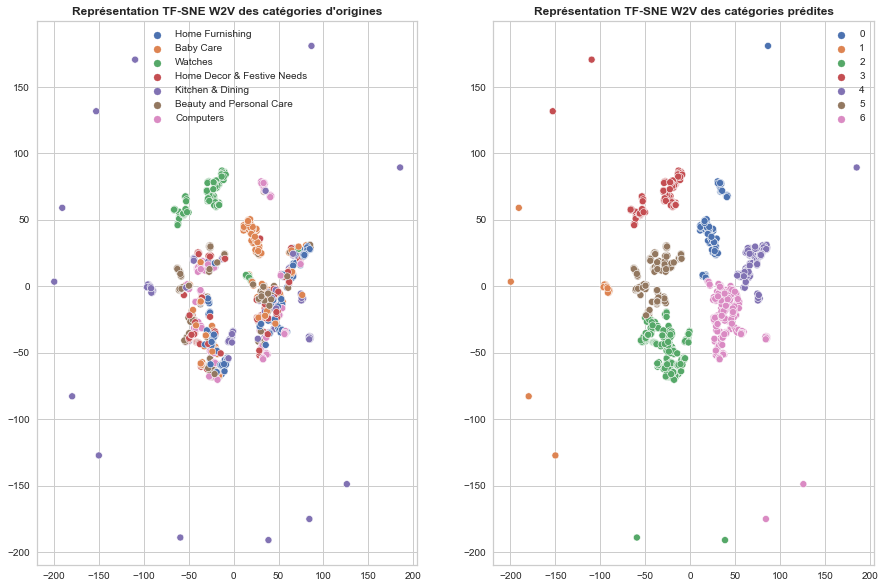

In [151]:
# w2v

# Réduction de dimension par t-SNE

tsne_results_w2v = tsne.fit_transform(X_w2v) 
T=tsne_results_w2v
# KMeans sur les 7 catégories
km_w2v=km.fit(tsne_results_w2v)
visualizer=SilhouetteVisualizer(km)
visualizer.fit(tsne_results_w2v)
visualizer.poof()
sil = silhouette_score(T,km.labels_,metric="euclidean")
print("Le score de silhouette est", sil)


labels_w2v = km.labels_

#rajouter les nouveaux labels au dataframe 
data['predicted_category_w2v'] =labels_w2v
predicted_clusters_w2v = data['predicted_category_w2v'] 


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(T[:,0],T[:,1],hue=labels_true,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE W2V des catégories d'origines", fontweight='bold')

ax = fig.add_subplot(1,2,2)
sns.scatterplot(T[:,0],T[:,1],hue=labels_w2v,legend='full', palette='deep')
ax.set_title("Représentation TF-SNE W2V des catégories prédites", fontweight='bold')
plt.show()

w2v_km_scores = clusters_scores(T,labels_w2v, labels_true, 'w2v_Kmeans')

In [152]:
# compare scores
compare_km = pd.concat([svd_tf_km_scores, svd_tfidf_km_scores], axis=1)
compare_km = pd.concat([compare_km, tsne_tf_km_scores], axis=1)
compare_km = pd.concat([compare_km, tsne_tfidf_km_scores], axis=1)
compare_km = pd.concat([compare_km, svd_bert_km_scores], axis=1)
compare_km = pd.concat([compare_km, tsne_bert_km_scores], axis=1)
compare_km = pd.concat([compare_km, svd_use_km_scores], axis=1)
compare_km = pd.concat([compare_km, tsne_use_km_scores], axis=1)
compare_km = pd.concat([compare_km,lda_tf_km_scores],axis=1)
compare_km = pd.concat([compare_km,lda_tfidf_km_scores],axis=1)
compare_km= pd.concat([compare_km,nmf_tf_km_scores],axis=1)
compare_km= pd.concat([compare_km,nmf_tfidf_km_scores],axis=1)
compare_km= pd.concat([compare_km,w2v_km_scores],axis=1)
compare_km


svd_tf_Kmeans  svd_tfidf_Kmeans  tsne_tf_Kmeans  \
Homogeneity        0.320497          0.485696        0.475388   
Completeness       0.193321          0.407960        0.465171   
V_measure          0.241170          0.443447        0.470224   
ARI                0.071505          0.194402        0.357502   
sil_scor          -0.191498          0.026700        0.455265   

              tsne_tfidf_Kmeans  svd_bert_Kmeans  tsne_bert_Kmeans  \
Homogeneity            0.521351         0.441250          0.437335   
Completeness           0.511856         0.402347          0.418656   
V_measure              0.516560         0.420902          0.427792   
ARI                    0.407434         0.237345          0.261455   
sil_scor               0.463916         0.230811          0.445599   

              svd_bert_Kmeans  tsne_use_Kmeans  lda_tf_Kmeans  \
Homogeneity          0.437335         0.563576       0.268048   
Completeness         0.418656         0.555964       0.221924   
V_measure            0.427792         0.559744       0.242815   
ARI                  0.261455         0.446889       0.138938   
sil_scor             0.286302         0.461946      -0.065553   

              lda_tfidf_Kmeans  nmf_tf_Kmeans  nmf_tfidf_Kmeans  w2v_Kmeans  
Homogeneity           0.189820       0.493339          0.628142    0.312164  
Completeness          0.110981       0.364508          0.421932    0.292275  
V_measure             0.140069       0.419249          0.504790    0.301892  
ARI                   0.076113       0.201058          0.183864    0.192983  
sil_scor             -0.015467       0.002471          0.227822    0.502902

In [153]:
df_compare=compare_km.T
df_compare

Homogeneity  Completeness  V_measure       ARI  sil_scor
svd_tf_Kmeans         0.320497      0.193321   0.241170  0.071505 -0.191498
svd_tfidf_Kmeans      0.485696      0.407960   0.443447  0.194402  0.026700
tsne_tf_Kmeans        0.475388      0.465171   0.470224  0.357502  0.455265
tsne_tfidf_Kmeans     0.521351      0.511856   0.516560  0.407434  0.463916
svd_bert_Kmeans       0.441250      0.402347   0.420902  0.237345  0.230811
tsne_bert_Kmeans      0.437335      0.418656   0.427792  0.261455  0.445599
svd_bert_Kmeans       0.437335      0.418656   0.427792  0.261455  0.286302
tsne_use_Kmeans       0.563576      0.555964   0.559744  0.446889  0.461946
lda_tf_Kmeans         0.268048      0.221924   0.242815  0.138938 -0.065553
lda_tfidf_Kmeans      0.189820      0.110981   0.140069  0.076113 -0.015467
nmf_tf_Kmeans         0.493339      0.364508   0.419249  0.201058  0.002471
nmf_tfidf_Kmeans      0.628142      0.421932   0.504790  0.183864  0.227822
w2v_Kmeans            0.312164      0.292275   0.301892  0.192983  0.502902

In [154]:
# Comparaison visuelle 
df_comp_sort = df_compare.sort_values(by='ARI', ascending=False)
df_comp_sort

Homogeneity  Completeness  V_measure       ARI  sil_scor
tsne_use_Kmeans       0.563576      0.555964   0.559744  0.446889  0.461946
tsne_tfidf_Kmeans     0.521351      0.511856   0.516560  0.407434  0.463916
tsne_tf_Kmeans        0.475388      0.465171   0.470224  0.357502  0.455265
tsne_bert_Kmeans      0.437335      0.418656   0.427792  0.261455  0.445599
svd_bert_Kmeans       0.437335      0.418656   0.427792  0.261455  0.286302
svd_bert_Kmeans       0.441250      0.402347   0.420902  0.237345  0.230811
nmf_tf_Kmeans         0.493339      0.364508   0.419249  0.201058  0.002471
svd_tfidf_Kmeans      0.485696      0.407960   0.443447  0.194402  0.026700
w2v_Kmeans            0.312164      0.292275   0.301892  0.192983  0.502902
nmf_tfidf_Kmeans      0.628142      0.421932   0.504790  0.183864  0.227822
lda_tf_Kmeans         0.268048      0.221924   0.242815  0.138938 -0.065553
lda_tfidf_Kmeans      0.189820      0.110981   0.140069  0.076113 -0.015467
svd_tf_Kmeans         0.320497      0.193321   0.241170  0.071505 -0.191498

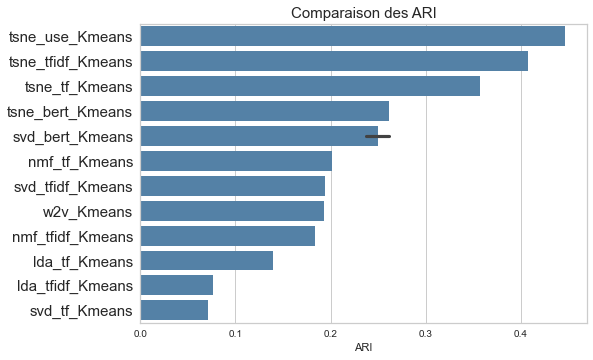

In [155]:
sns.barplot(x=df_comp_sort['ARI'],y=df_comp_sort.index, color='SteelBlue')
plt.xticks(fontsize=10)
plt.yticks(fontsize=15)
plt.title('Comparaison des ARI', fontsize=15)
plt.show()

## bilan

Pour la réduction de dimension, t-SNE et TSVD suivi de t-SNE comportent des biens meilleurs résultats que TSVD seule
USE obtient des meilleurs résultats.

In [156]:
# exporter data
data.to_csv('data_clean.csv')

In [159]:
df_compare.to_csv('compare.csv')